In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [2]:
train_df = pd.read_table("2013_Queensland_Floods_train.tsv")
test_df = pd.read_table("2013_Queensland_Floods_test.tsv")
col_names = train_df.columns
train_df["text"]

0       I just though about the night I went clubbing ...
1       Looks like its going to be another long night ...
2       @LaniiBanani hahahaha I just told him id have ...
3       Off to meeting.... with so called... Baaps of ...
4                Doubt I'll be getting much sleep tonight
                              ...                        
6014    RT @GrillTeam: The Queensland government has s...
6015    Can we have 5 NEMA staff from Nigeria  come to...
6016    RT @7NewsBrisbane: Foam from rough waves at Al...
6017    RT @abcsouthqld: Master Electricians Australia...
6018    RT @HomeLoanKing: Leader of Aussie opposition,...
Name: text, Length: 6019, dtype: object

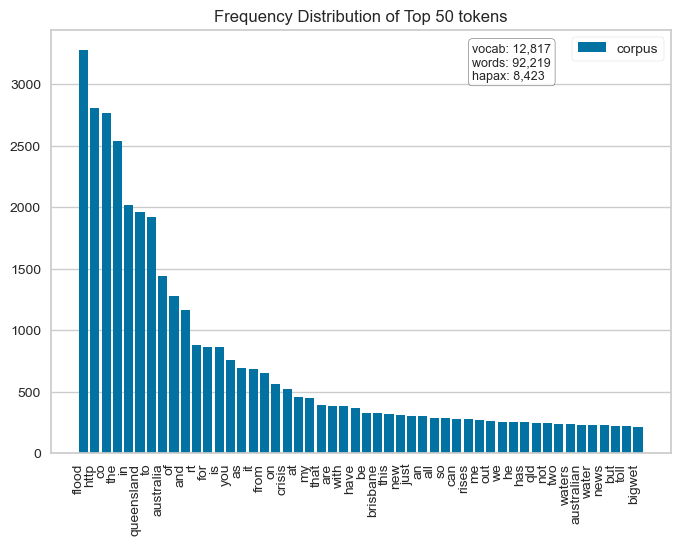

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [3]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(train_df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
train_text = train_df["text"]
train_labels = train_df["label"]

test_text = test_df["text"]
test_labels = test_df["label"]

print(train_text.shape)
print(test_text.shape)

(6019,)
(3011,)


In [5]:
# remove digits, @-mentions, links, stopwords

train_text = train_text.str.lower()
#train_text = train_text.apply(lambda elem: re.sub(r"\d+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
train_text = train_text.apply(lambda x : nltk.word_tokenize(x))
train_text = train_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

test_text = test_text.str.lower()
#test_text = test_text.apply(lambda elem: re.sub(r"\d+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
test_text = test_text.apply(lambda x : nltk.word_tokenize(x))
test_text = test_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

train_text.shape

(6019,)

In [6]:
# include the hashtag anyway because #savehaiti is different from savehaiti
train_text = train_text.apply(lambda elem: re.sub(r"#", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\.", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\,", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\?", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\!", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\:", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\;", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\-", " ", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\'", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\_", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\/", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\*", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\%", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\&", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\\", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@\s[a-zA-Z0-9]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\$", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\[", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\]", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\~", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\(", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\)", "", elem))
train_text = train_text.apply(lambda elem: re.sub("http", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\s\s*", " ", elem))
train_text = train_text.apply(lambda elem: re.sub(r"^\s+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\s+$", "", elem))

test_text = test_text.apply(lambda elem: re.sub(r"#", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\.", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\,", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\?", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\!", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\:", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\;", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\-", " ", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\'", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\_", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\/", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\*", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\%", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\&", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\\", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@\s[a-zA-Z0-9]+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\$", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\[", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\]", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\~", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\(", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\)", "", elem))
test_text = test_text.apply(lambda elem: re.sub("http", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\s\s*", " ", elem))
test_text = test_text.apply(lambda elem: re.sub(r"^\s+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\s+$", "", elem))


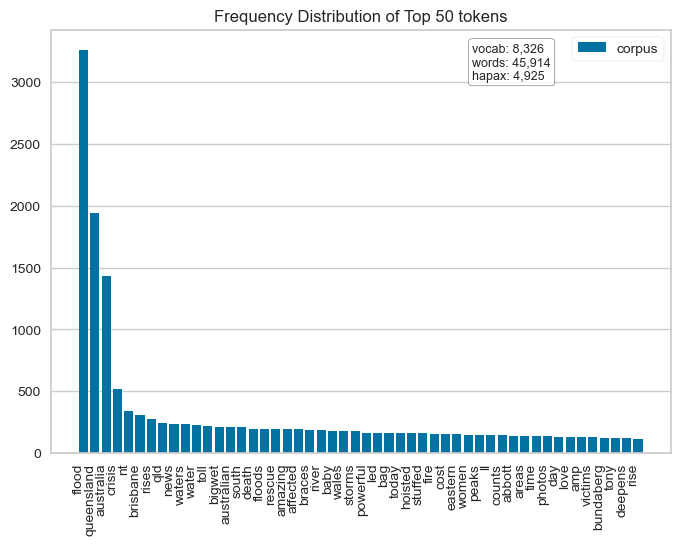

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [7]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(pd.DataFrame(train_text)["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

b'not_relevant' 	 0.46037547765409537
b'relevant' 	 0.5396245223459046


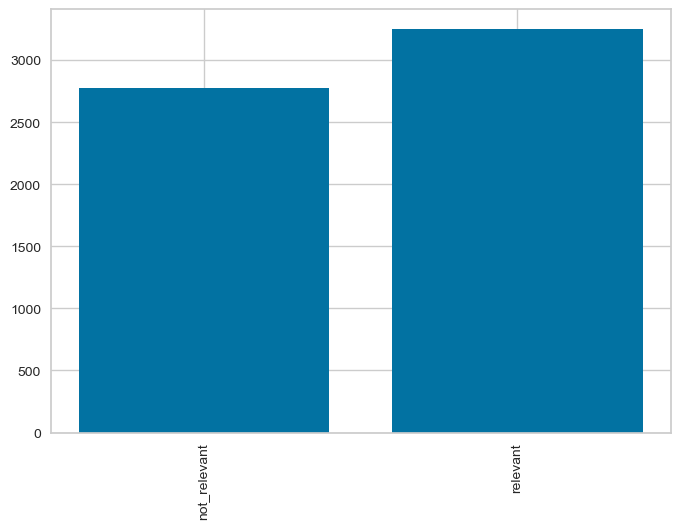

In [8]:
train_text = tf.convert_to_tensor(train_text)
train_labels = tf.convert_to_tensor(train_labels)

test_text = tf.convert_to_tensor(test_text)
test_labels = tf.convert_to_tensor(test_labels)

labels = tf.unique(train_labels)[0]
#print(np.array(tf.unique(train_labels)[1]))

for x in range(0,len(labels)):
  print(np.array(labels)[x], '\t', np.mean(x == tf.unique(train_labels)[1]))
plt.bar(np.array(labels), [np.sum(x == tf.unique(train_labels)[1]) for x in range(0,len(labels))])
plt.xticks(rotation = 90)
plt.show()

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
X_train, _, y_train, _ = train_test_split(np.array(train_text), np.array(train_labels), train_size=500, shuffle=True)
for i in range(len(X_train)):
  X_train[i] = str(X_train[i])[2:-1]
  X_train[i] = tokenizer.tokenize(X_train[i])
  X_train[i] = tokenizer.convert_tokens_to_ids(X_train[i])

X_test, _, y_test, _ = train_test_split(np.array(test_text), np.array(test_labels), train_size=100, shuffle=True)
for i in range(len(X_test)):
  X_test[i] = str(X_test[i])[2:-1]
  X_test[i] = tokenizer.tokenize(X_test[i])
  X_test[i] = tokenizer.convert_tokens_to_ids(X_test[i])

In [11]:
import torch

max_length = 64
model.config.max_position_embeddings = max_length

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [12]:
print(X_train_padded)

tensor([[ 5322,  1055,  7186,  ...,     0,     0,     0],
        [ 7186,  4788,  3619,  ...,     0,     0,     0],
        [ 1017,  3134,  2187,  ...,     0,     0,     0],
        ...,
        [17472,  5322,  7186,  ...,     0,     0,     0],
        [ 4532, 14556,     0,  ...,     0,     0,     0],
        [ 2293,  6669, 22313,  ...,     0,     0,     0]], dtype=torch.int32)


In [13]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 2.2763e-01,  5.1779e-01,  3.5703e-01,  ..., -5.4528e-01,
           2.3965e-01,  4.8686e-02],
         [ 3.2953e-01,  6.3161e-01,  2.9286e-01,  ..., -7.1998e-01,
           3.2832e-01, -5.1922e-02],
         [ 4.0715e-01,  6.7354e-01, -4.7986e-04,  ..., -1.0562e+00,
          -4.7746e-02, -3.1420e-01],
         ...,
         [ 3.8323e-01,  5.1318e-01,  7.8299e-01,  ..., -5.4676e-01,
           5.0784e-01,  1.9239e-01],
         [ 3.6304e-01,  5.2243e-01,  7.9402e-01,  ..., -5.1843e-01,
           5.0712e-01,  2.0239e-01],
         [ 3.6981e-01,  5.8568e-01,  7.6985e-01,  ..., -5.1527e-01,
           4.8688e-01,  1.8421e-01]],

        [[-9.2731e-02,  1.1260e-01, -4.3788e-02,  ..., -8.3239e-01,
           6.8637e-01,  1.0103e-01],
         [-1.8729e-01,  3.7954e-01,  9.1912e-02,  ..., -8.2281e-01,
           3.9661e-01, -6.4996e-02],
         [-2.6731e-01,  1.9018e-01,  5.2392e-02,  ..., -8.1271e-01,
           4.

In [14]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-2.4037e-01, -1.2916e-03, -5.3780e-03,  ..., -2.8259e-01,
           6.4897e-01, -1.4581e-01],
         [-3.5439e-01,  5.8499e-01,  6.1523e-01,  ..., -1.9749e-01,
           2.2793e-01,  1.6426e-01],
         [-2.7198e-01,  4.2888e-01,  5.2187e-01,  ..., -1.3850e-01,
           1.5454e-01,  2.1859e-01],
         ...,
         [-2.0003e-01, -5.9606e-02,  3.8140e-01,  ..., -3.4023e-01,
           7.0614e-01, -1.8338e-01],
         [-1.9541e-01, -4.3415e-02,  3.7656e-01,  ..., -3.1684e-01,
           7.2835e-01, -1.7424e-01],
         [-1.8303e-01, -1.2962e-02,  3.2124e-01,  ..., -3.1380e-01,
           7.2226e-01, -1.7064e-01]],

        [[ 1.4556e-01,  5.1528e-01,  3.7373e-01,  ..., -2.9206e-01,
           2.0879e-01,  6.6980e-02],
         [-2.3327e-01,  5.1149e-01,  4.2908e-01,  ..., -6.0309e-01,
          -1.0770e-01,  9.3307e-02],
         [-1.6498e-01,  7.3903e-01,  2.0263e-01,  ..., -5.3836e-01,
          -3.

In [15]:
print(bert_train_output[0].shape, bert_train_output[1].shape)
print(bert_test_output[0].shape, bert_test_output[1].shape)
print(type(bert_train_output[0]))

torch.Size([500, 64, 768]) torch.Size([500, 768])
torch.Size([100, 64, 768]) torch.Size([100, 768])
<class 'torch.Tensor'>


In [16]:
train_sequence_output = bert_train_output[0].detach().numpy().copy()
X_train = train_sequence_output.reshape(X_train.shape[0], 64*768)

test_sequence_output = bert_test_output[0].detach().numpy().copy()
X_test = test_sequence_output.reshape(X_test.shape[0], 64*768)

bert_train_output = None
bert_test_output = None

In [17]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [18]:
clf = neural_network.MLPClassifier()
clf.fit(X_train, le.transform(y_train))

MLPClassifier()

In [19]:
clf2 = neural_network.MLPClassifier()
clf2.fit(X_train_padded, le.transform(y_train))

MLPClassifier()

In [20]:
print("Train accuracy:", np.mean(clf.predict(X_train) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf.predict(X_test) == le.transform(y_test)))

print("Train accuracy:", np.mean(clf2.predict(X_train_padded) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf2.predict(X_test_padded) == le.transform(y_test)))

Train accuracy: 0.998
Test accuracy: 0.91
Train accuracy: 0.918
Test accuracy: 0.54


## SHAP

In [21]:
shap.initjs()

In [22]:
X_test_padded = np.array(X_test_padded)

In [23]:
permutation_explainer = shap.explainers.Permutation(clf2.predict, X_test_padded)


In [24]:
permutation_values = permutation_explainer(X_test_padded)

In [25]:
print(permutation_values)

.values =
array([[-0.0875    , -0.0325    , -0.135     , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0175    , -0.00416667,  0.03083333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15916667, -0.01833333,  0.16833333, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.05      ,  0.02416667, -0.16083333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00083333,  0.0125    ,  0.0975    , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0375    ,  0.03      ,  0.2125    , ...,  0.        ,
         0.        ,  0.        ]])

.base_values =
array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
 

Sentence: baby ##y ##y game co ##s n ##xt the ##week ##nd ##ly ##ric ##s bed ##time ##music ; Prediction: [0] ; True value: b'not_relevant'


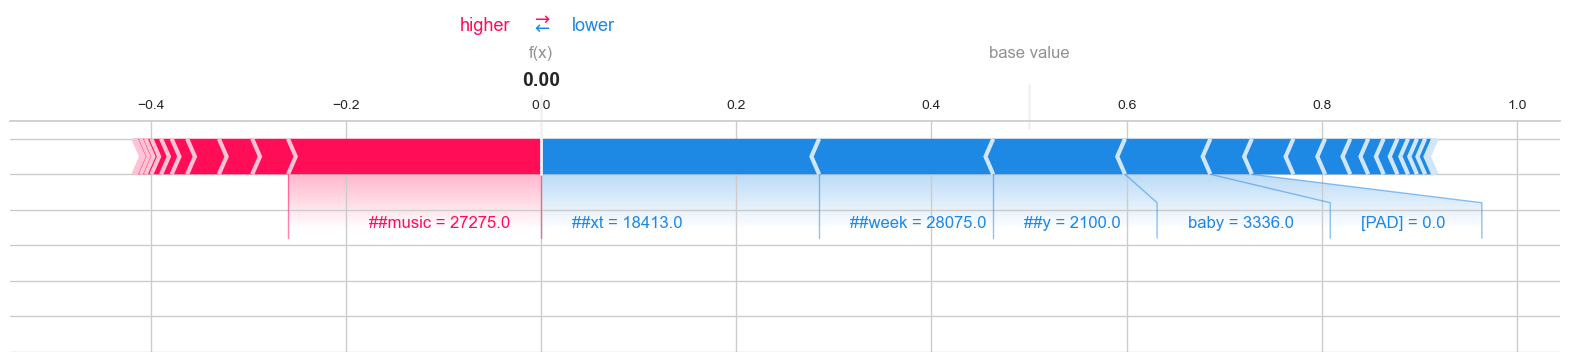

Sentence: queensland s flood crisis deep ##ens | australian tc ##o ##31 ##fs ##q ##ru ##z ; Prediction: [0] ; True value: b'relevant'


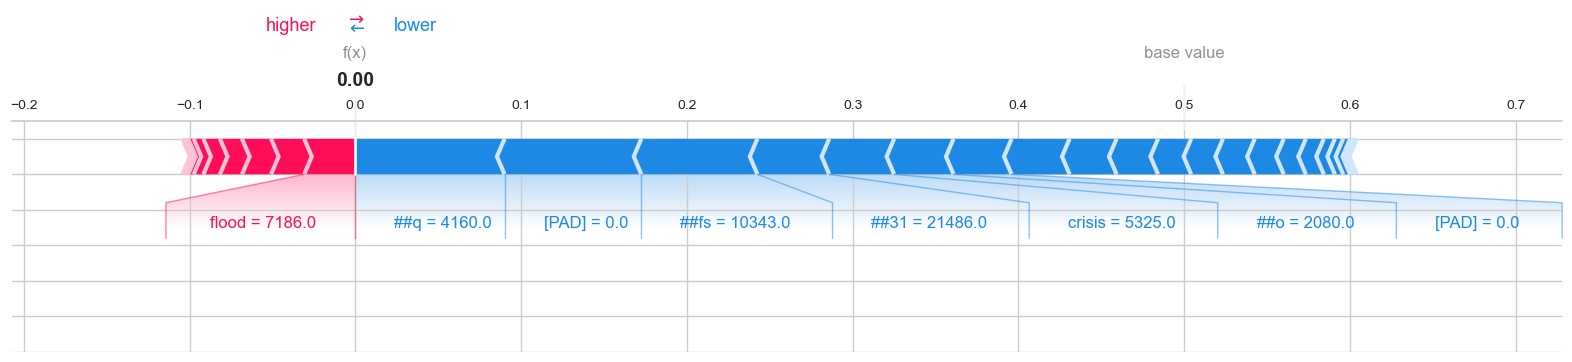

Sentence: nt stand alba ##nese weak ##ling excuse politician ; Prediction: [1] ; True value: b'not_relevant'


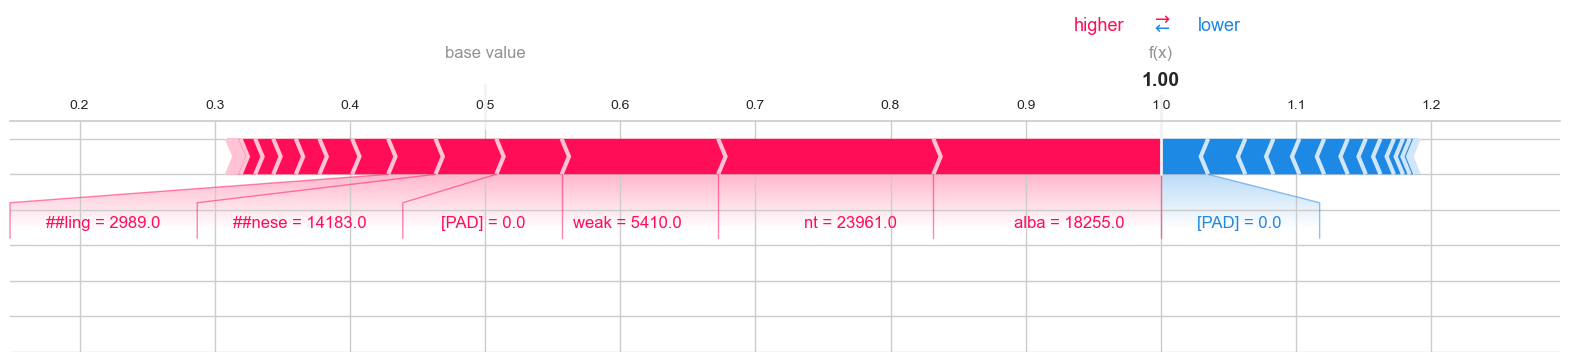

Sentence: brisbane great couple weeks ahead hit shower pro ##nto airport bn ##e w 2 tc ##od ##t ##nal ##t ##w ##h ; Prediction: [0] ; True value: b'not_relevant'


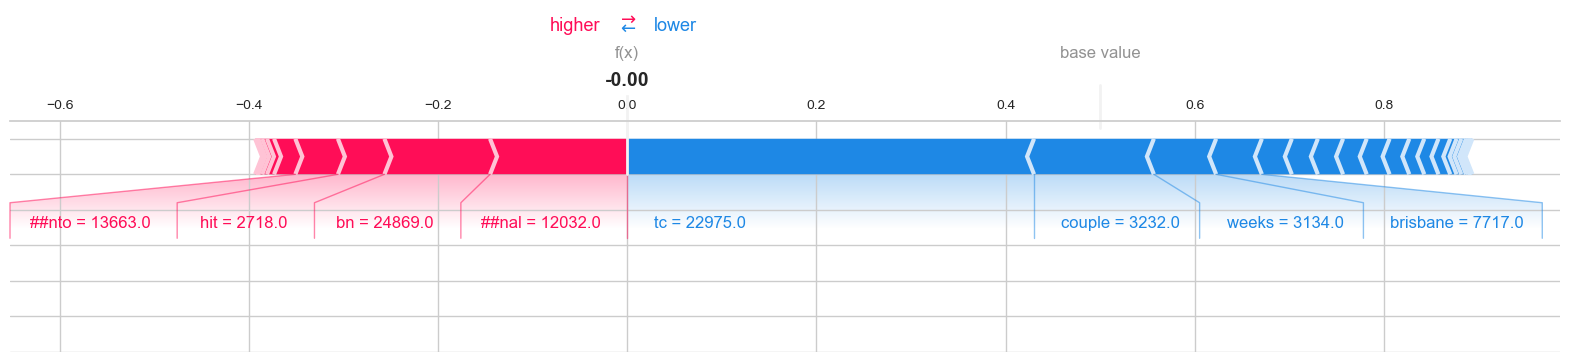

Sentence: part flood ridden part australia fine spare involved adam ##ino ##z ; Prediction: [1] ; True value: b'relevant'


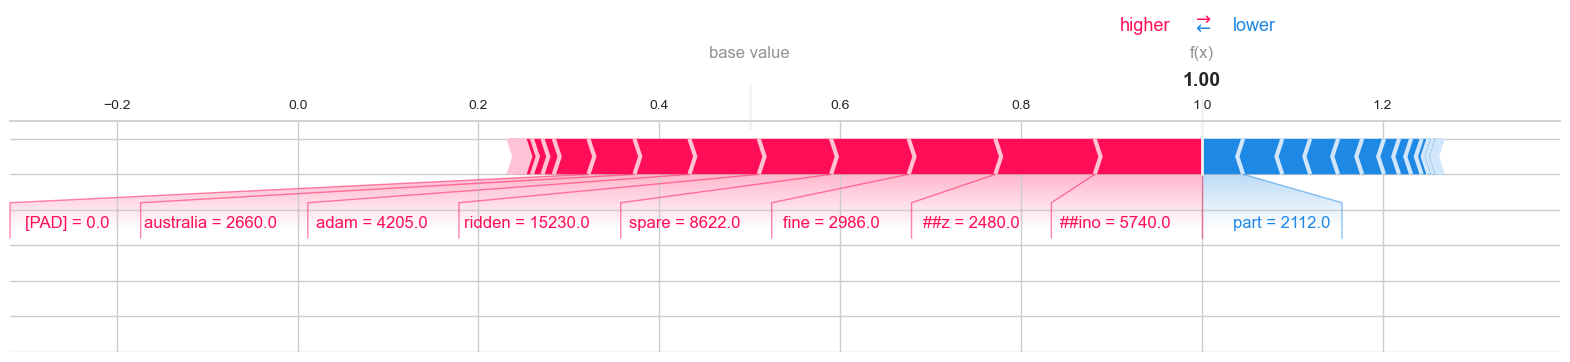

Sentence: australia faces flood crisis bbc s nick bryant reports rooftop rescues tc ##oh ##gb ##fk ##hc ##h ; Prediction: [1] ; True value: b'relevant'


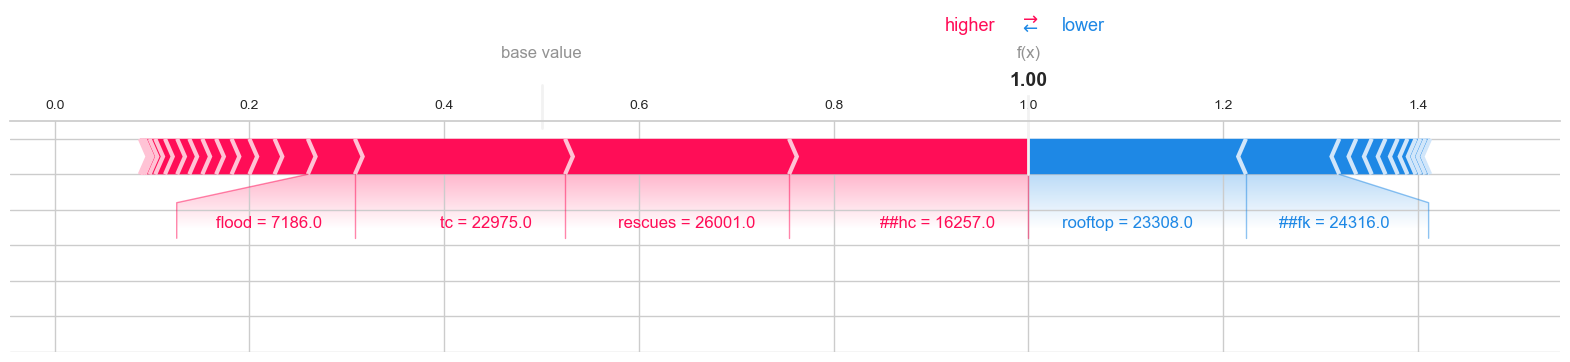

Sentence: love party ol ##p ol ##pl ##dr wynn ##e first ##fe ##mal ##ep ##rem ##ier ontario tc ##ov ##bc ##q ##h ##fr ##g ; Prediction: [1] ; True value: b'not_relevant'


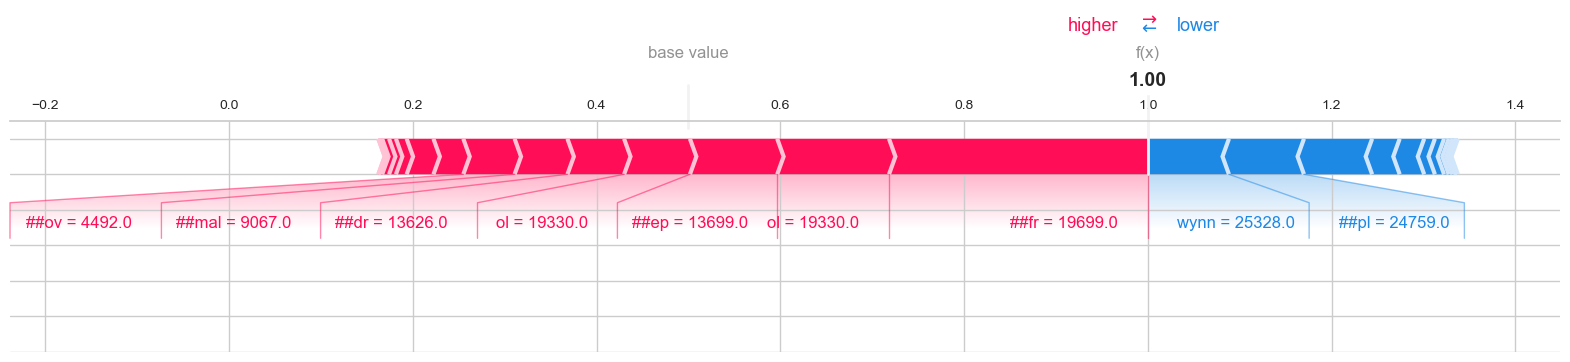

Sentence: excuse re showed boo ##bs ; Prediction: [1] ; True value: b'not_relevant'


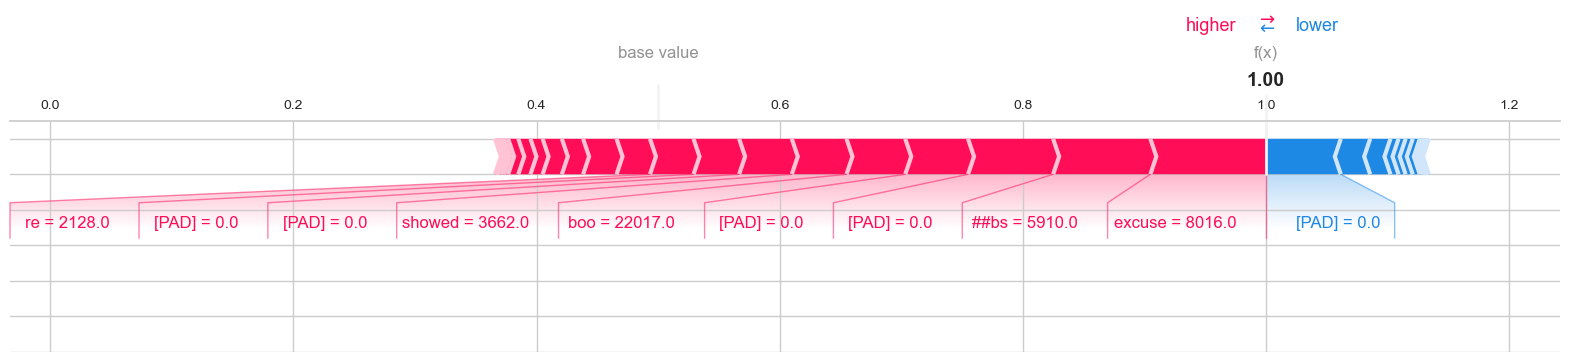

Sentence: great family elliot ; Prediction: [0] ; True value: b'not_relevant'


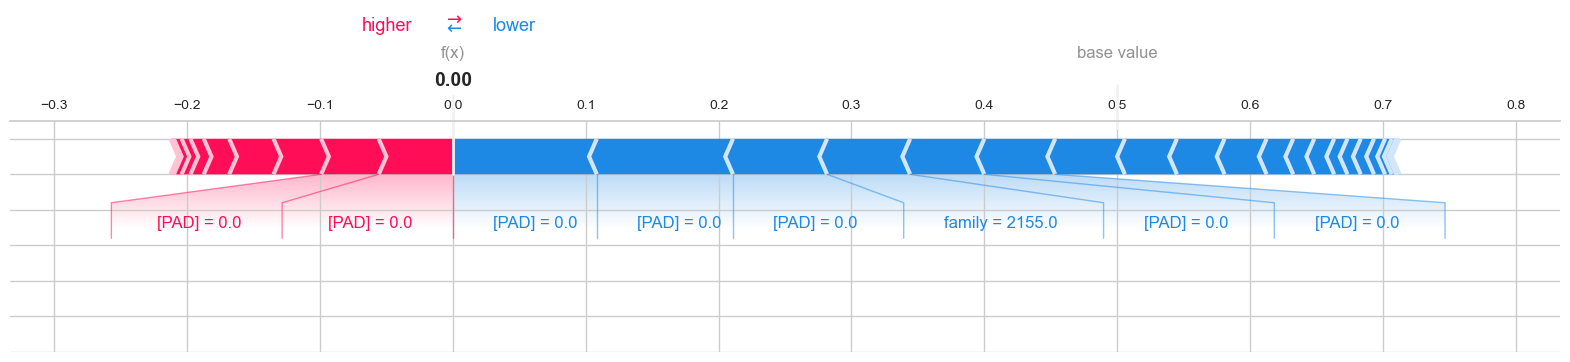

Sentence: moor ##ook ##a power hot shower day sand ##bag ##ging ; Prediction: [1] ; True value: b'relevant'


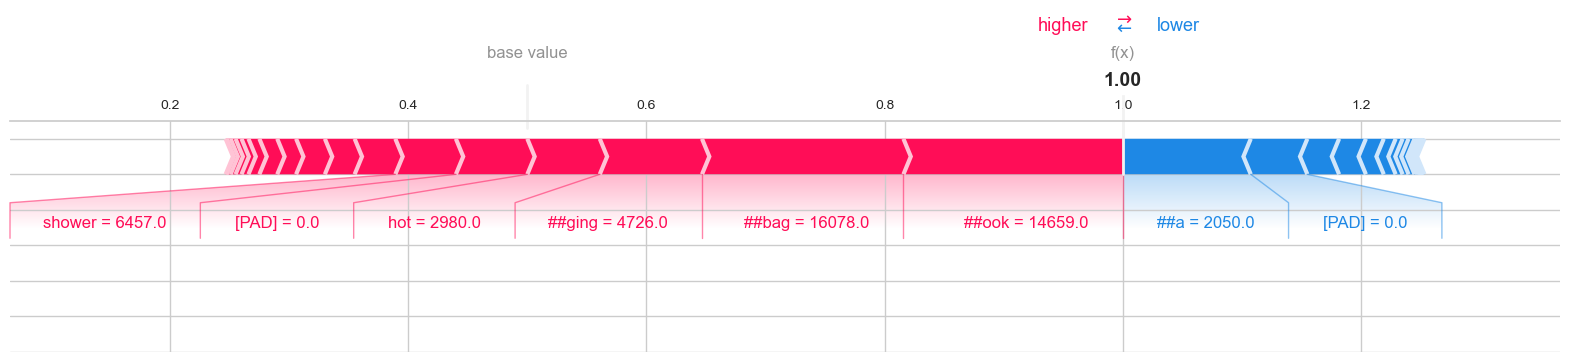

Sentence: thousands forced evacuate flooding eastern australia thousands forced evacuate homes due flood ; Prediction: [1] ; True value: b'relevant'


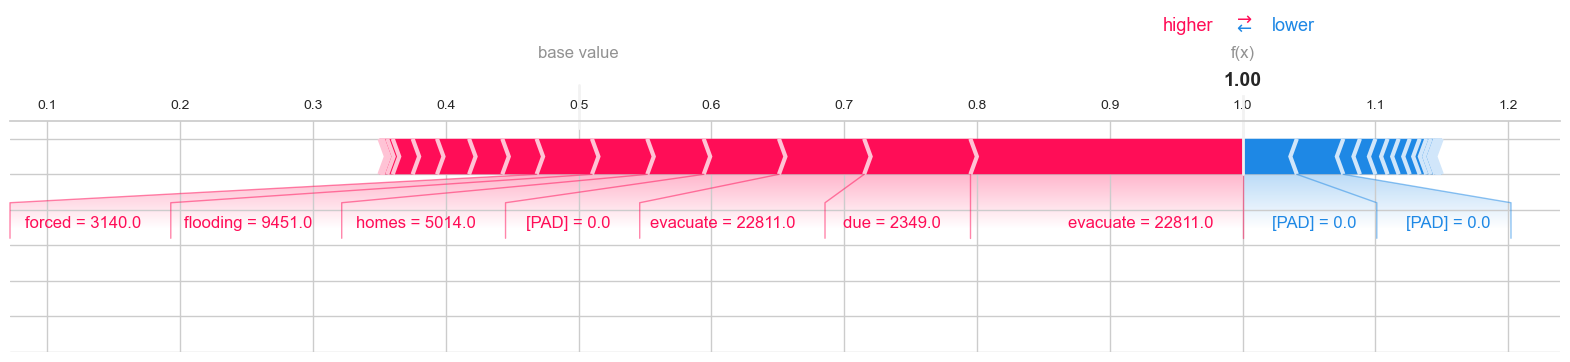

Sentence: wow sorry dar ##l barely twitter wow cool learn korean day xx head ##in work ; Prediction: [1] ; True value: b'not_relevant'


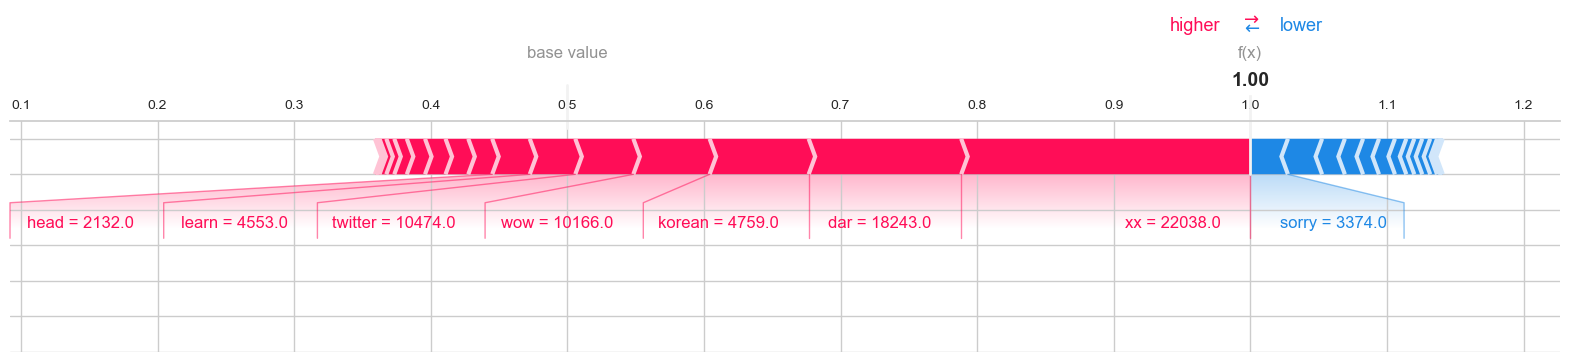

Sentence: photos flood water rises australia tc ##oc ##y ##b ##zy ##pt ##n ; Prediction: [1] ; True value: b'relevant'


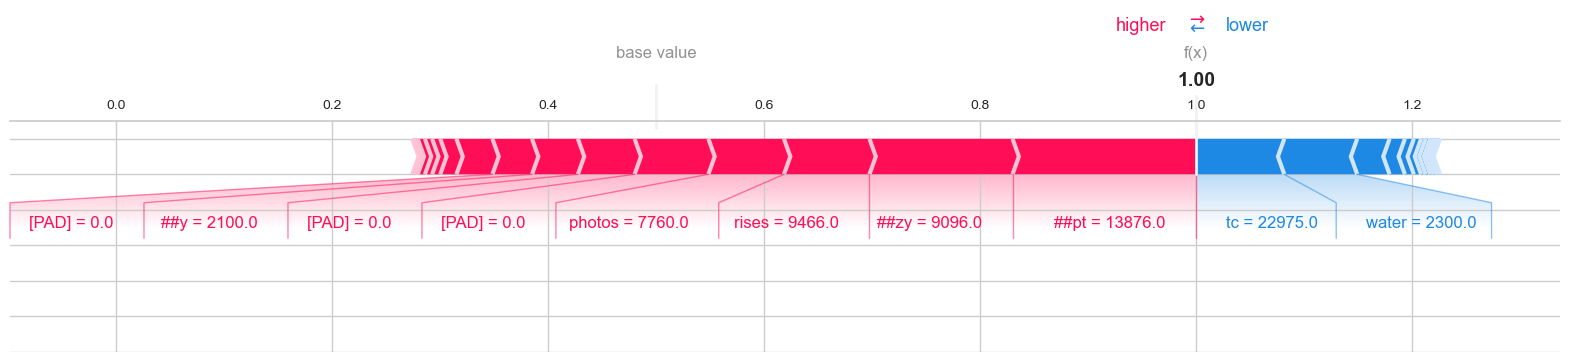

Sentence: celebrating needed rain dams full grass growing rapidly ; Prediction: [0] ; True value: b'not_relevant'


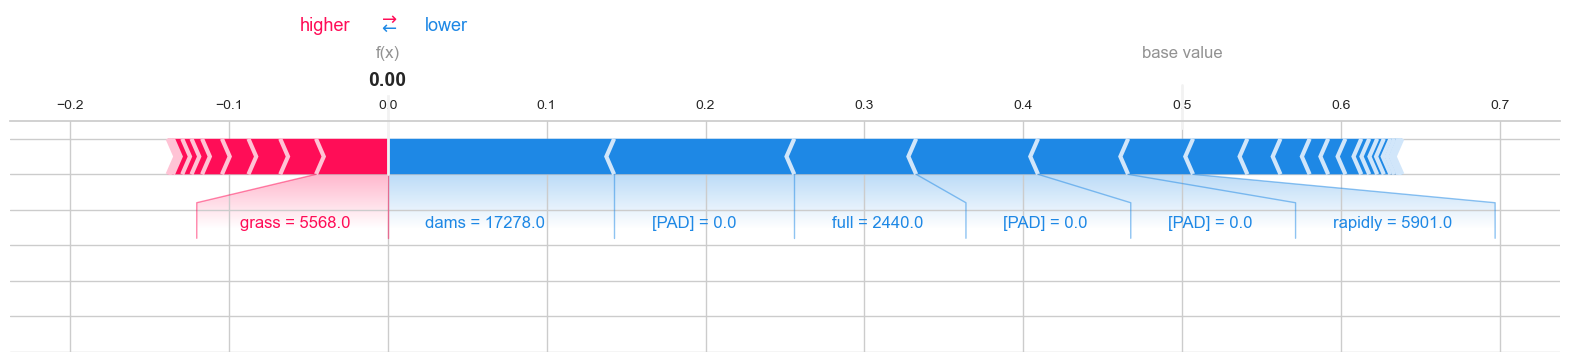

Sentence: illness recently crown hair nt 2 leave house anymore wig ##s r 2 hot n ##q ##ld advice ; Prediction: [0] ; True value: b'not_relevant'


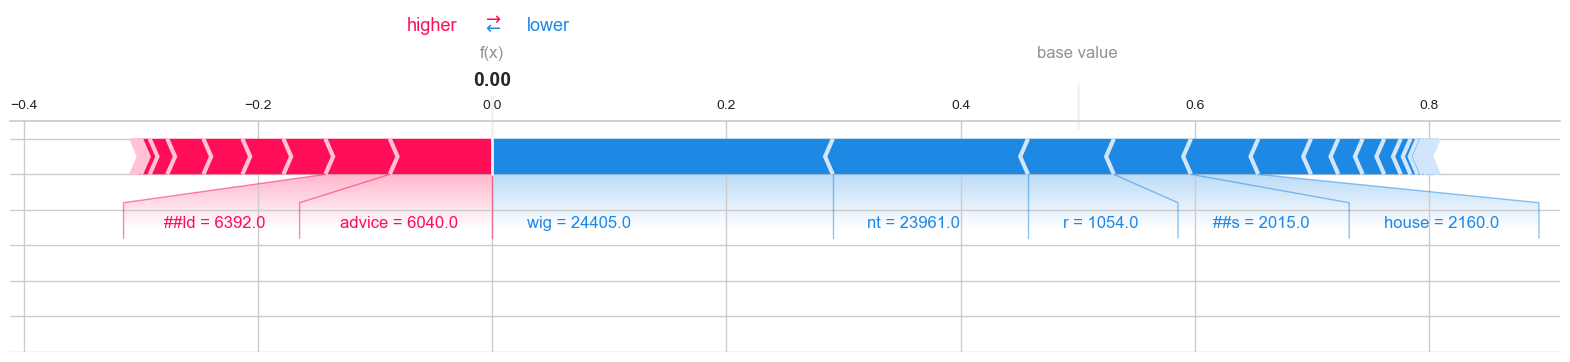

Sentence: south wales brace ##s river peaks queensland counts flood cost tc ##oc ##q ##op ##8 ##xa ##5 ; Prediction: [1] ; True value: b'relevant'


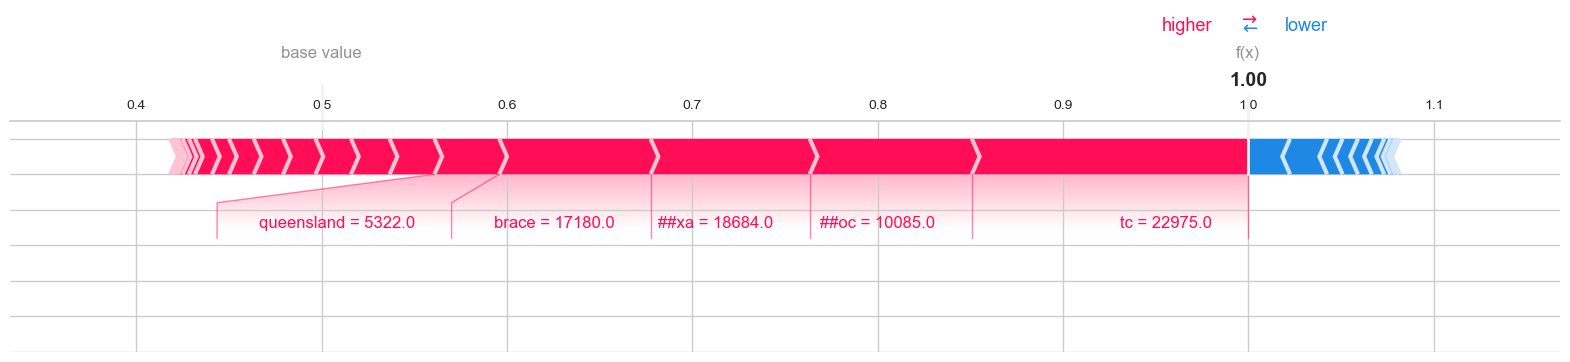

Sentence: sc ##umb ##ag abbott warned labor seek raise taxes pay flood relief queensland tc ##oz ##vo ##y ##gu ##g ##x ; Prediction: [1] ; True value: b'relevant'


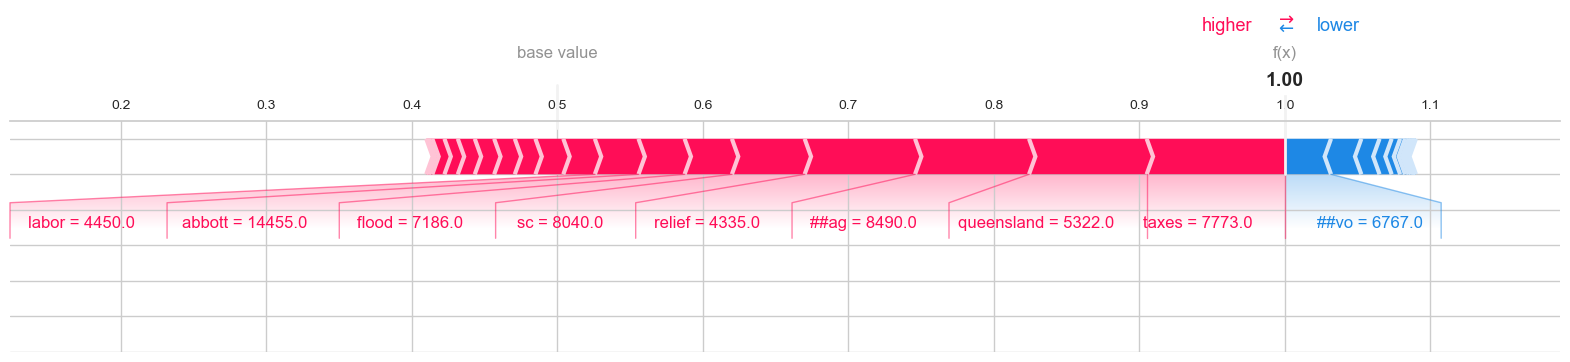

Sentence: kate council advises street flooding tomorrow s high tide 143 ##0 4 ; Prediction: [0] ; True value: b'relevant'


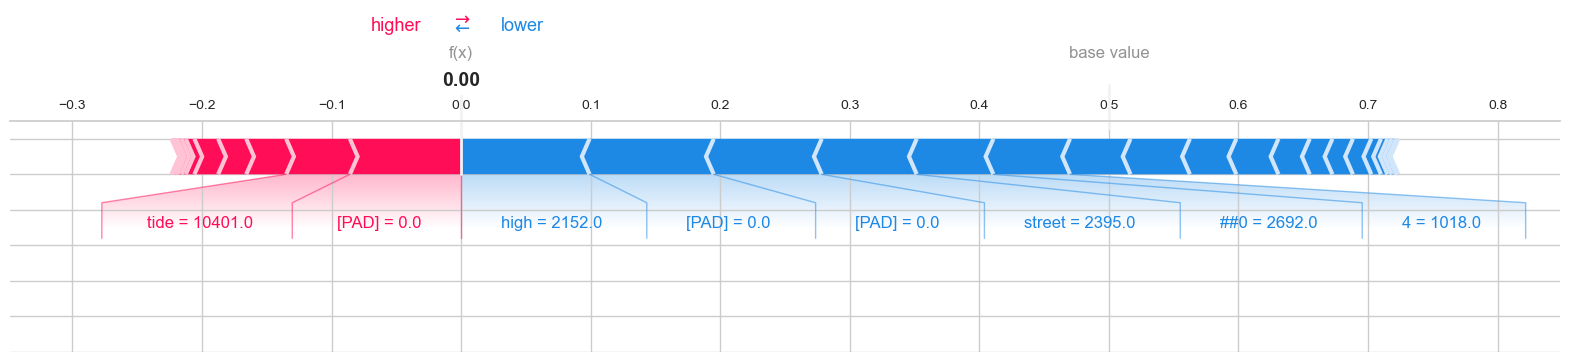

Sentence: follow appreciated love ; Prediction: [0] ; True value: b'not_relevant'


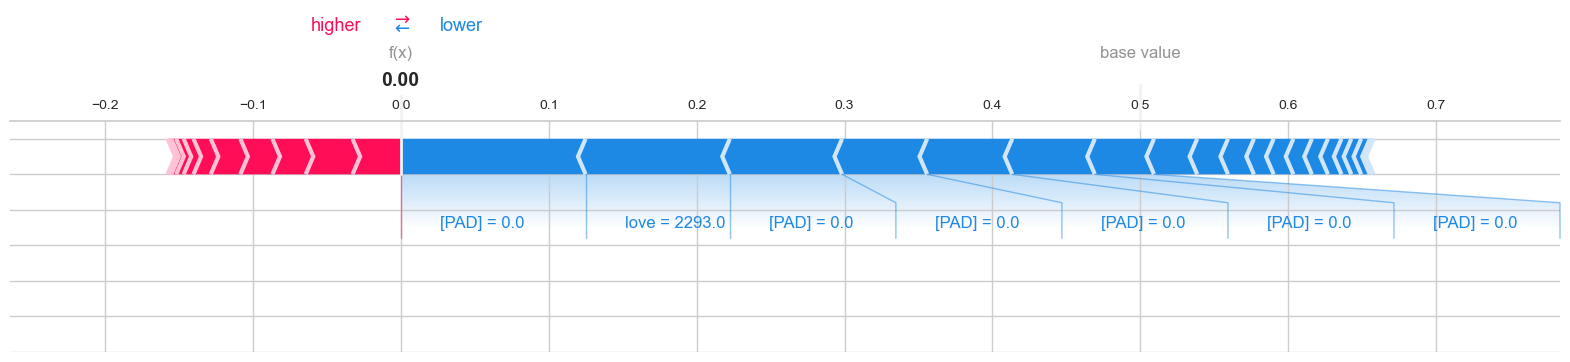

Sentence: legal grey area number ways rights packaged ; Prediction: [0] ; True value: b'not_relevant'


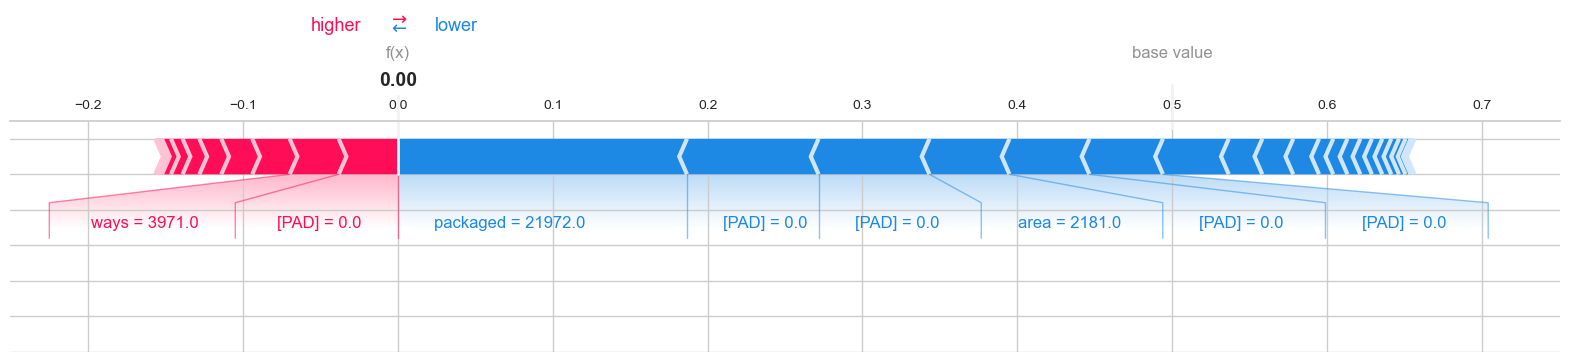

Sentence: australia continent country bush ##fire emergency flood emergency tornado emergency ; Prediction: [0] ; True value: b'relevant'


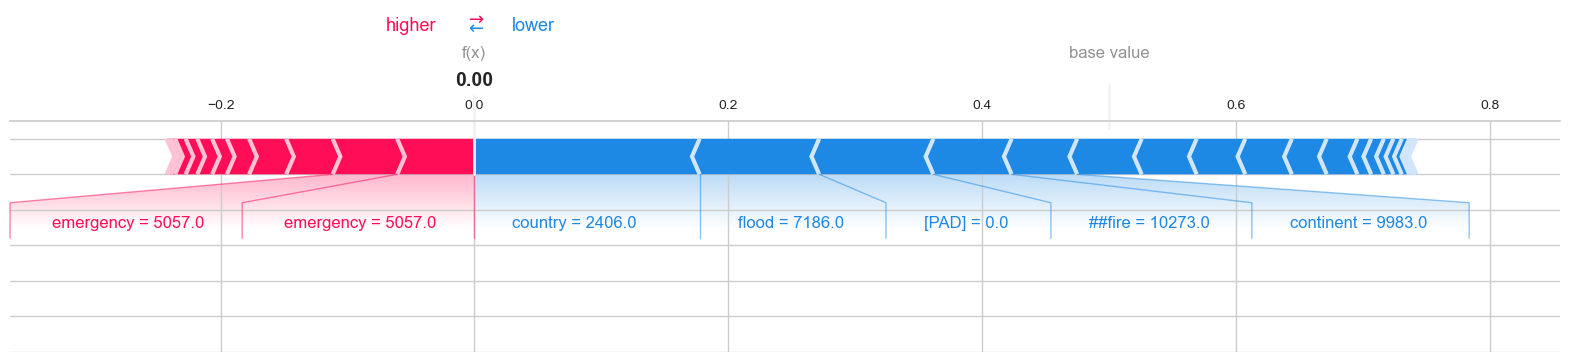

Sentence: bo ##ab fae river city 18th made sing bonnie tyler ha ##e video ; Prediction: [1] ; True value: b'not_relevant'


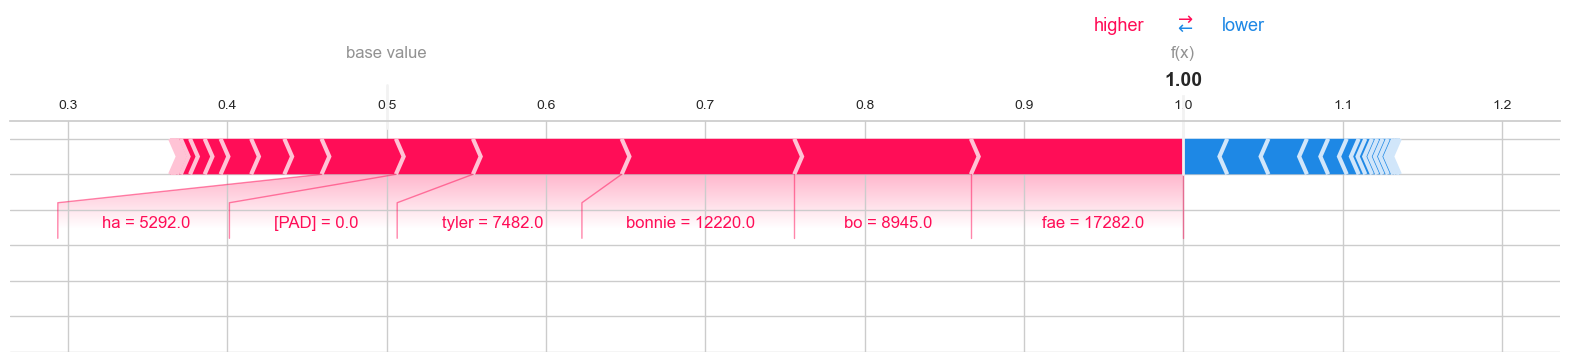

Sentence: god listening flood disaster happening queensland s devi ##sta ##ting ; Prediction: [1] ; True value: b'relevant'


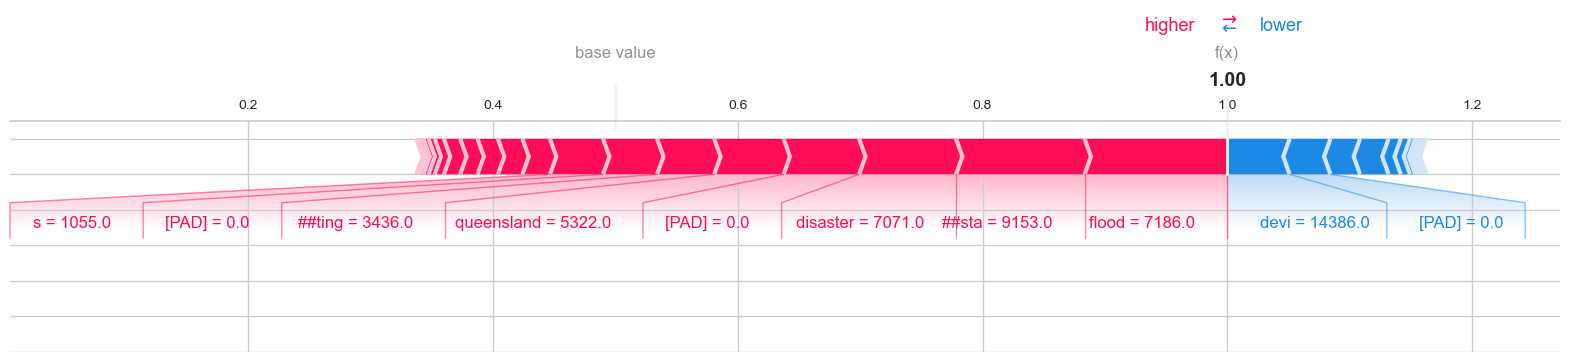

Sentence: brisbane fuck ##face fuck ##face s beaten tc ##oic ##ret ##dm ##e ; Prediction: [1] ; True value: b'not_relevant'


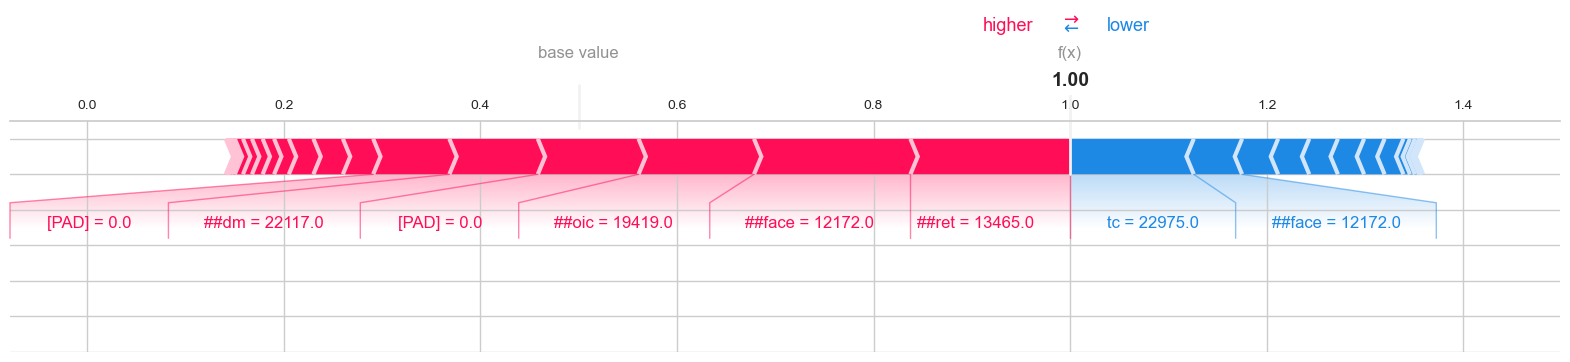

Sentence: ousted mayor winter ##gard ##en food court tc ##oc ##wa ##wy ##y ##0 ##6 ; Prediction: [0] ; True value: b'not_relevant'


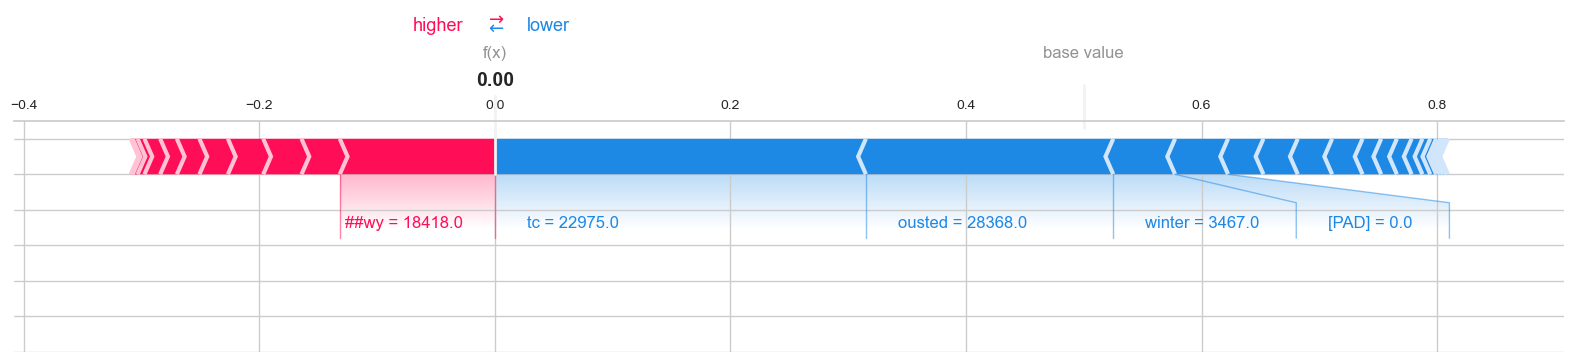

Sentence: queensland s flood crisis deep ##ens death toll rises australian tc ##ot ##r ##44 ##x ##9 ##fp ; Prediction: [0] ; True value: b'relevant'


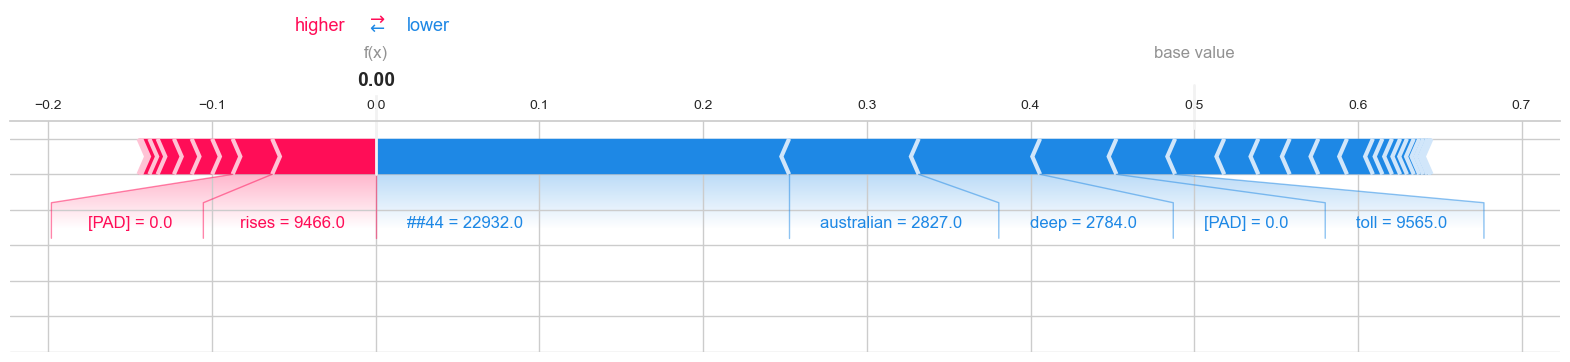

Sentence: flood affected flood safety check ##list queensland flood affected tc ##oa ##x ##k ##3 ##j ##1 ##et ; Prediction: [0] ; True value: b'relevant'


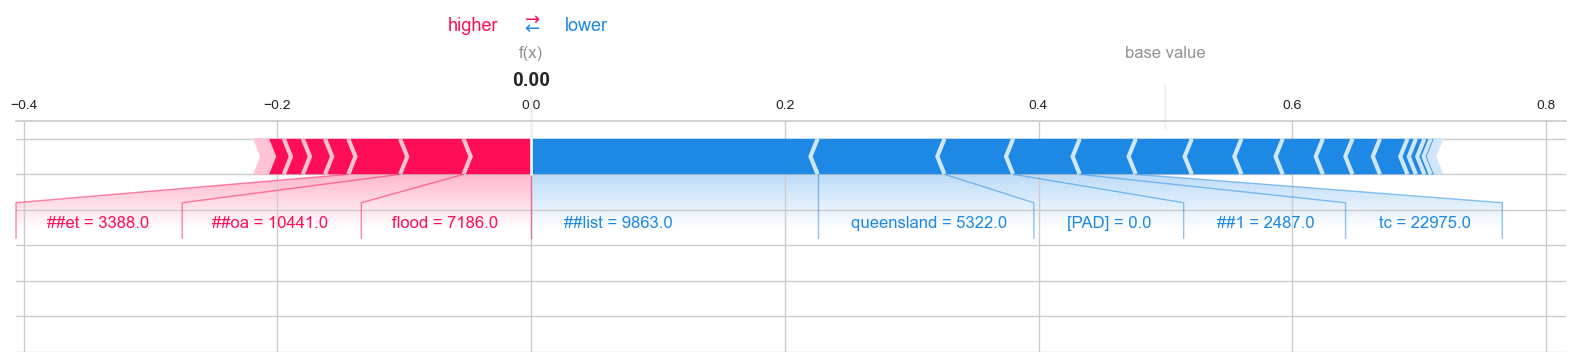

Sentence: flood hits queensland foam car appears tc ##o ##q ##ym ##y ##64 ##v ##3 ; Prediction: [0] ; True value: b'relevant'


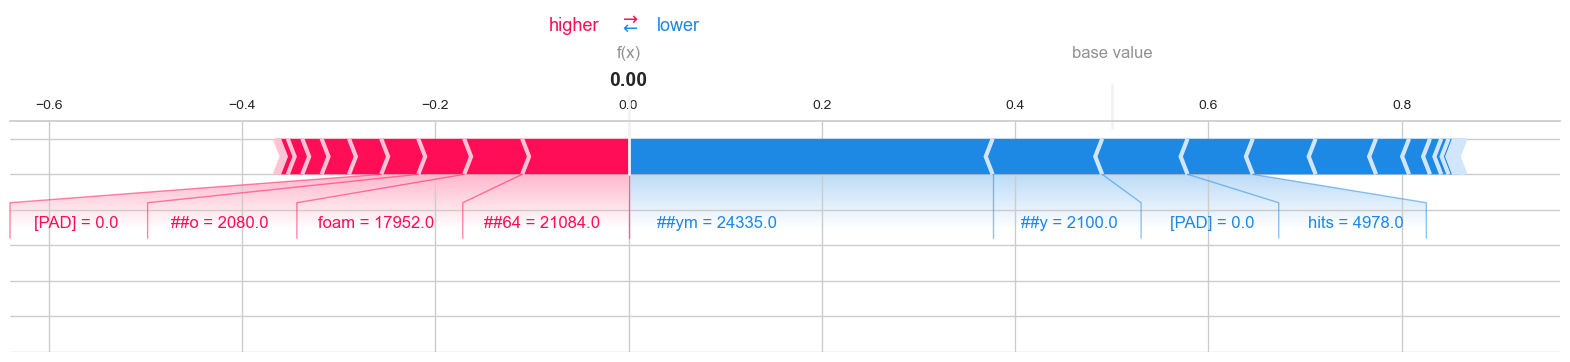

Sentence: needed leave cold weather ; Prediction: [1] ; True value: b'not_relevant'


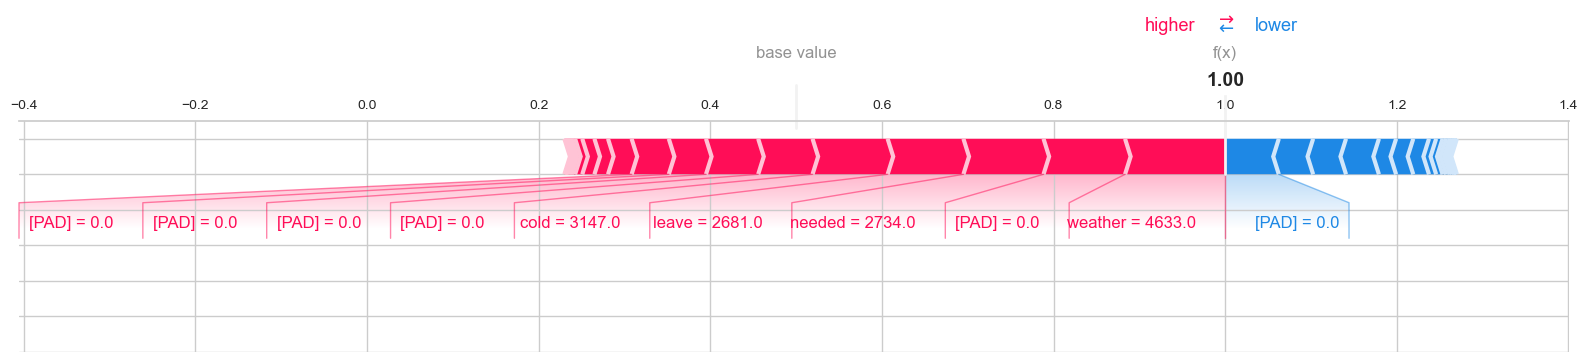

Sentence: deadly flood waters rise eastern australia dead torre ##ntial rains severely flood se ##ve tc ##o ##6 ##g ##xi ##4 ##sl ##9 ; Prediction: [0] ; True value: b'relevant'


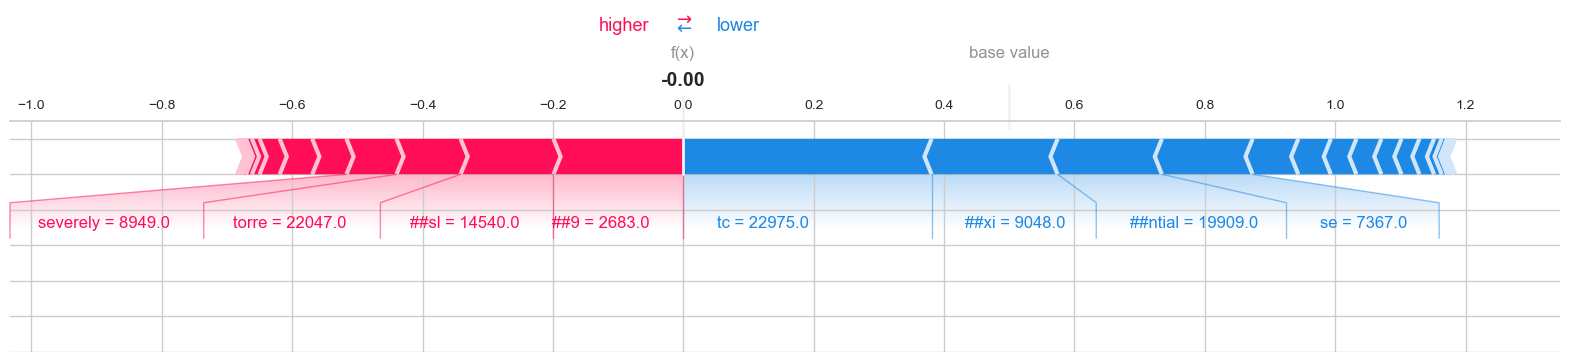

Sentence: adventist ##s melbourne australia collecting underwear bun ##da ##berg flood victims project call ; Prediction: [0] ; True value: b'relevant'


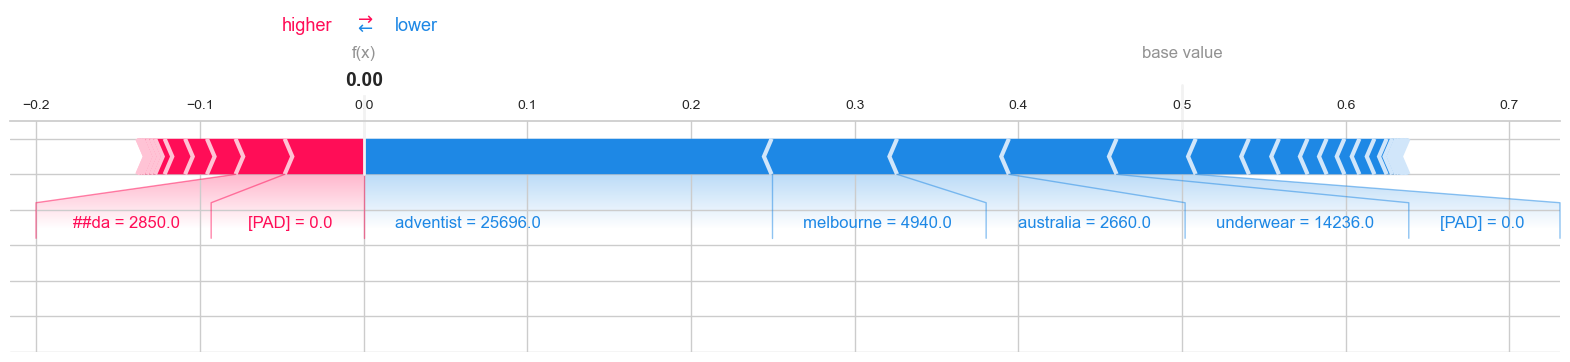

Sentence: damn weather ; Prediction: [0] ; True value: b'not_relevant'


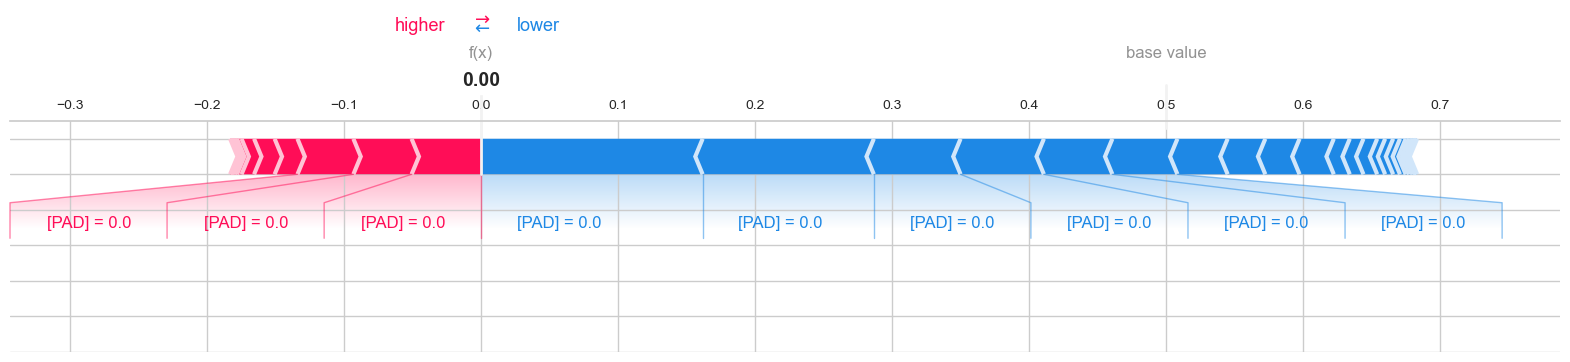

Sentence: australia flood disaster tc ##oa ##ma ##2 ##tm ##hh ; Prediction: [0] ; True value: b'relevant'


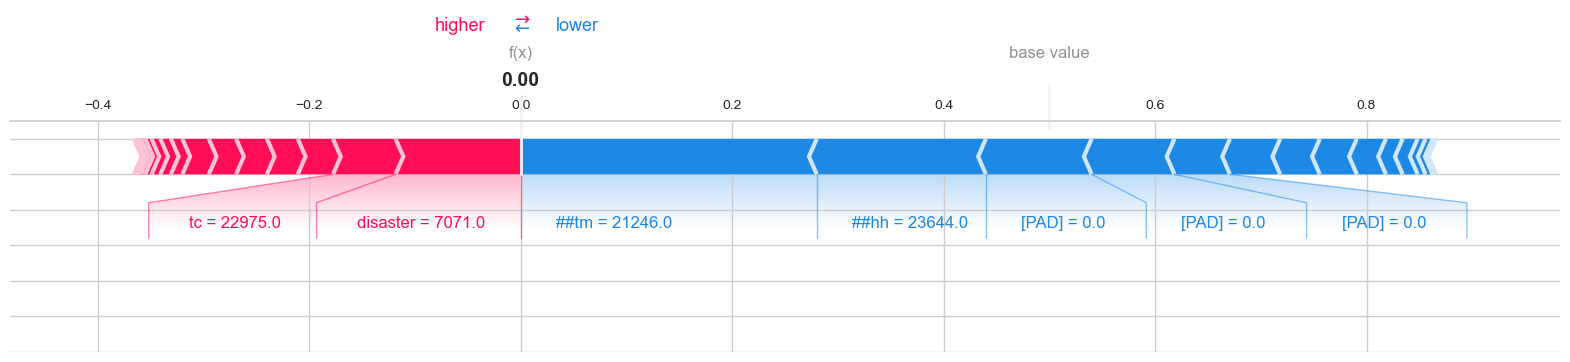

Sentence: baby stuffed bag hoisted flood australia s powerful storms led amazing rescue women tc ##oj ##l ##9 ##ty ##c ##9 ##e ; Prediction: [1] ; True value: b'relevant'


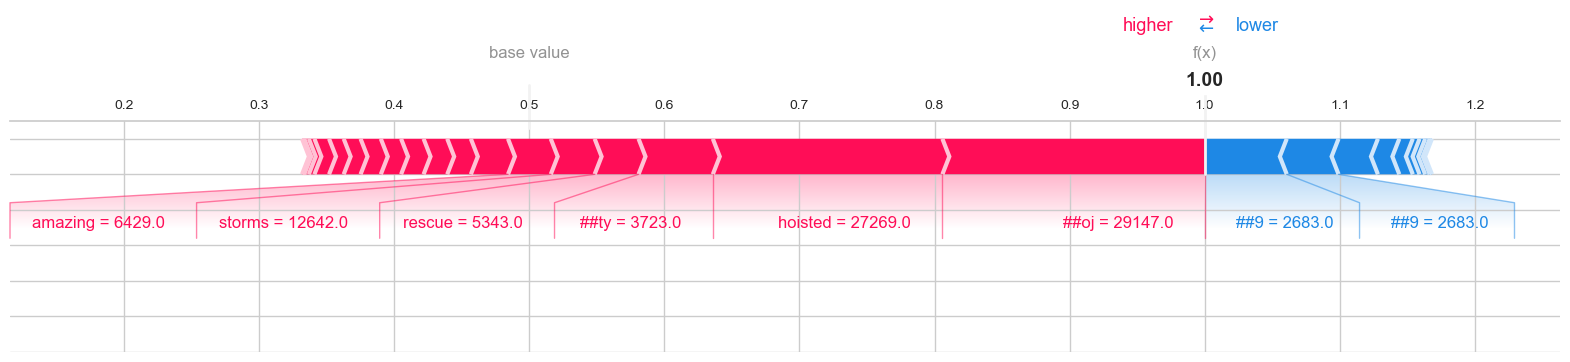

Sentence: time reading dr ##ib ##ble mate ; Prediction: [0] ; True value: b'not_relevant'


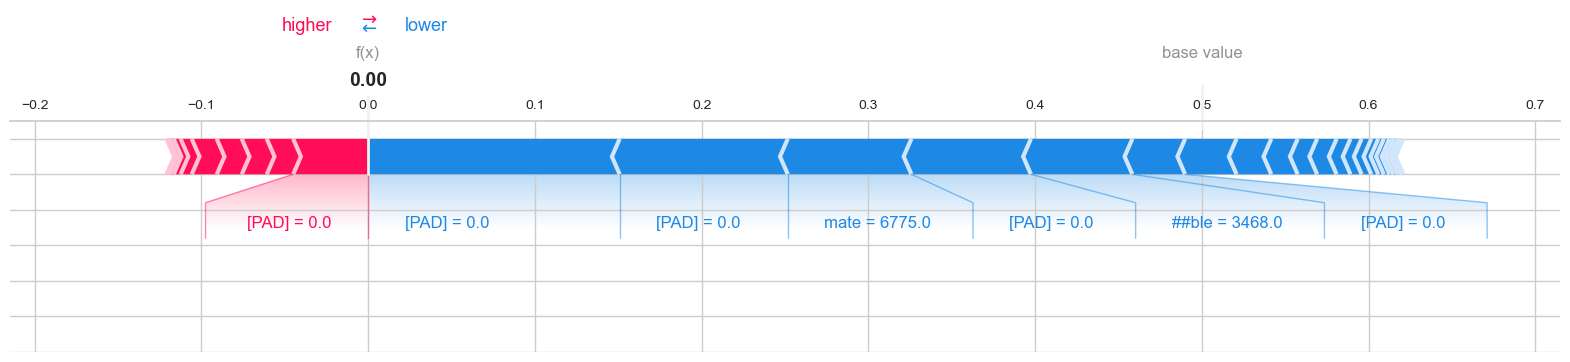

Sentence: newman mis ##qu ##oted wanting make queensland flood proof make flour ##ide proof ; Prediction: [1] ; True value: b'relevant'


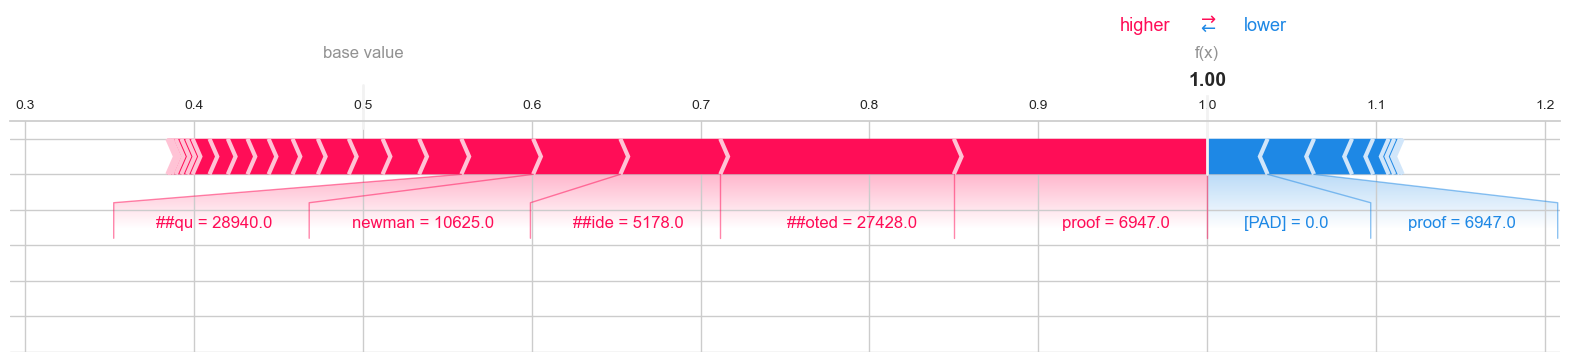

Sentence: australia lu ##rch ##es fire flood scientist tc ##o ##9 ##b ##jet ##6 ##z ##p ; Prediction: [1] ; True value: b'relevant'


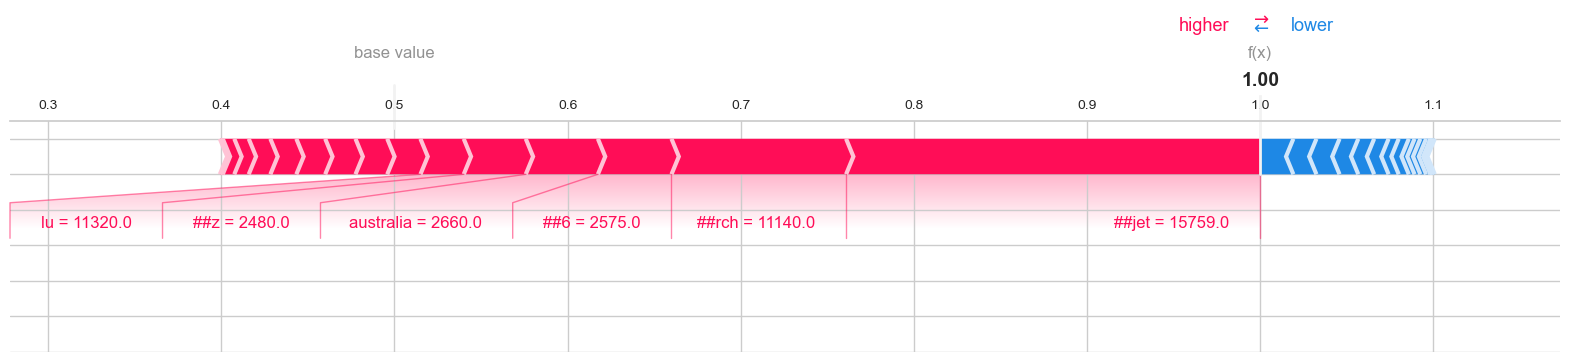

Sentence: uniting church australia flood appeal tc ##ow ##ker ##tt ##0 ##5 ; Prediction: [0] ; True value: b'relevant'


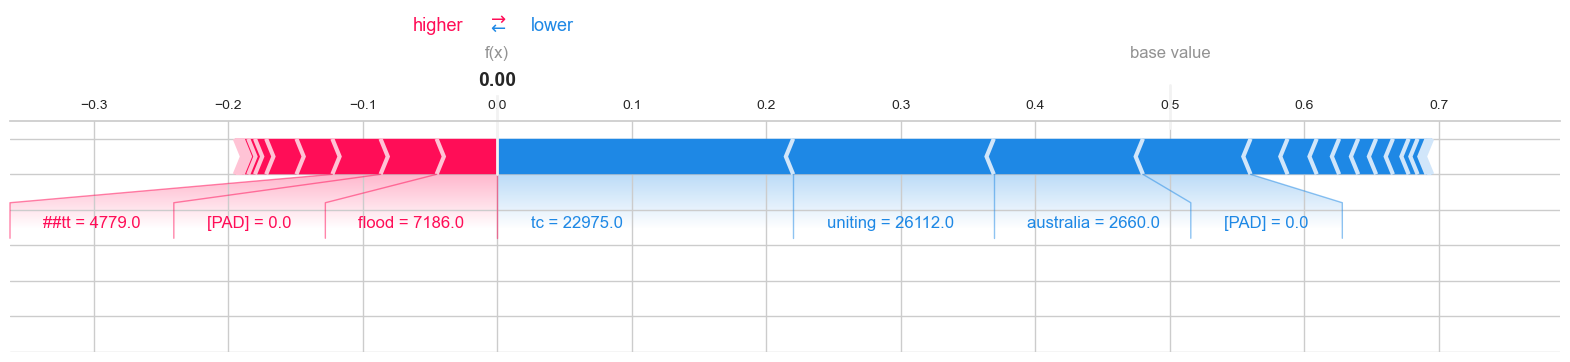

Sentence: friends family australia prayers devastated flood waters ; Prediction: [1] ; True value: b'relevant'


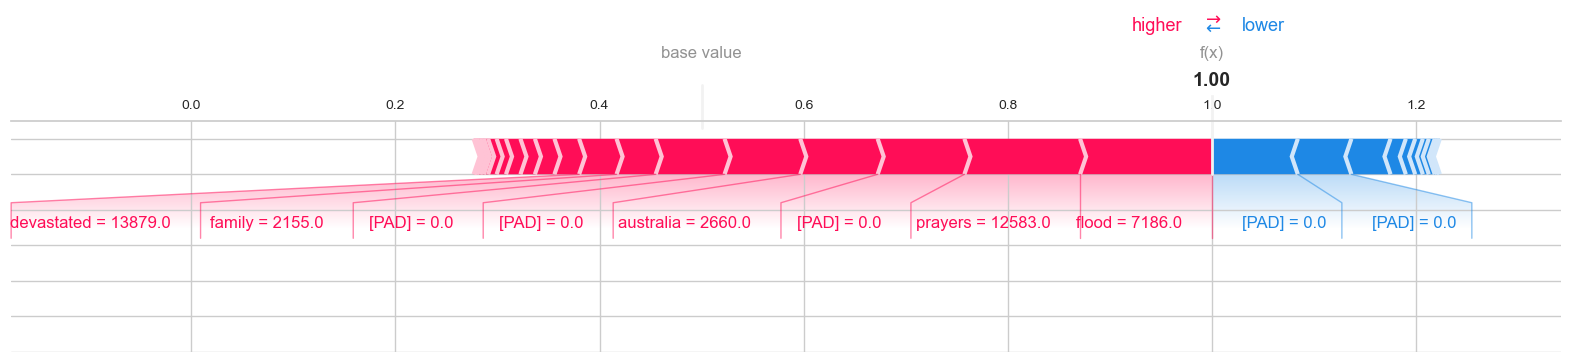

Sentence: queensland flood images tc ##ock ##x ##m ##hp ##np ; Prediction: [0] ; True value: b'relevant'


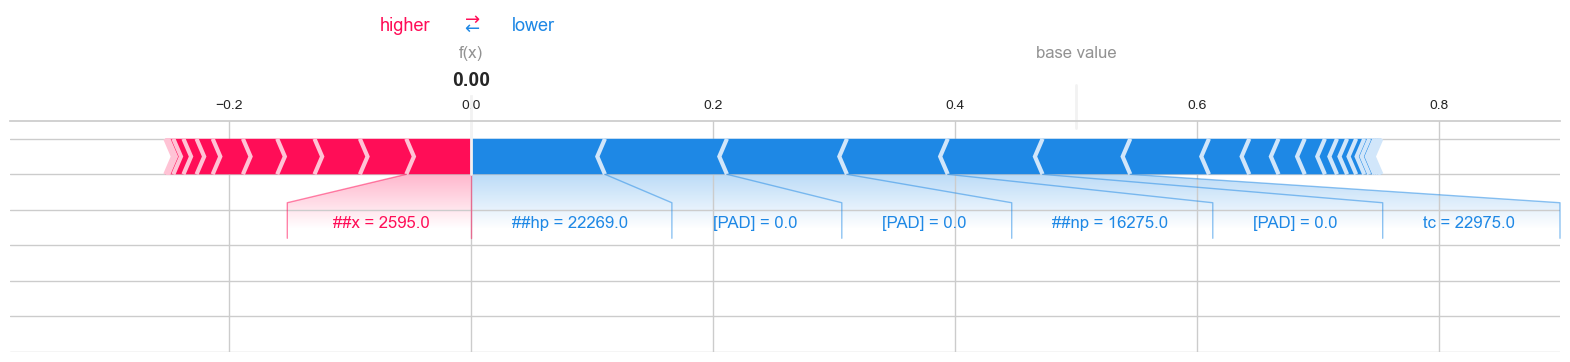

Sentence: put gang colors dancing make clip shoot ##you ##rse ##lf choose ##1 ; Prediction: [1] ; True value: b'not_relevant'


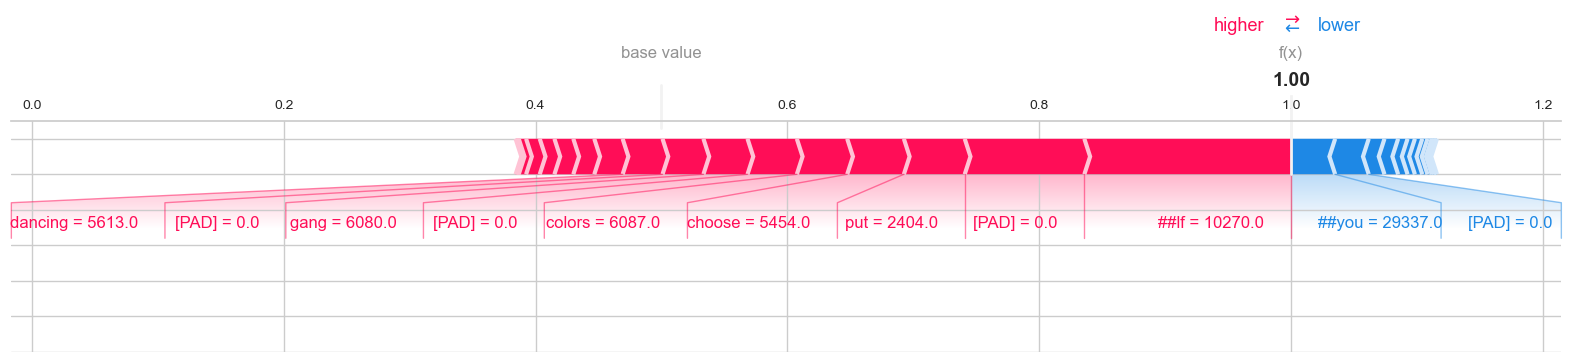

Sentence: australia lu ##rch ##es fire flood floods hit east coast australia recent bush fires tc ##og ##d ##x ##uf ##w ##b ##w ; Prediction: [0] ; True value: b'relevant'


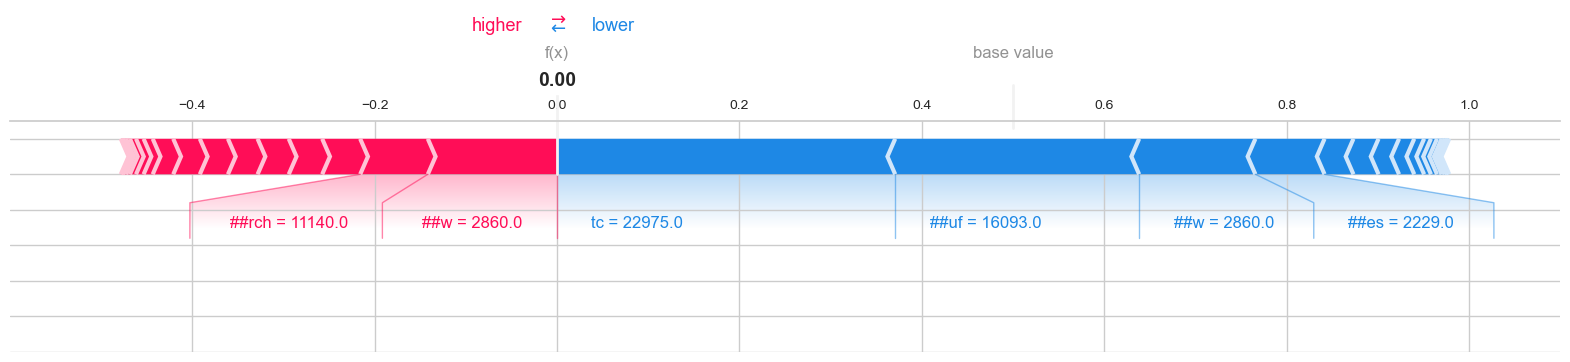

Sentence: thoughts families animals flood affected areas australia s east coast tc ##oza ##top ##7 ##c ##6 ; Prediction: [0] ; True value: b'relevant'


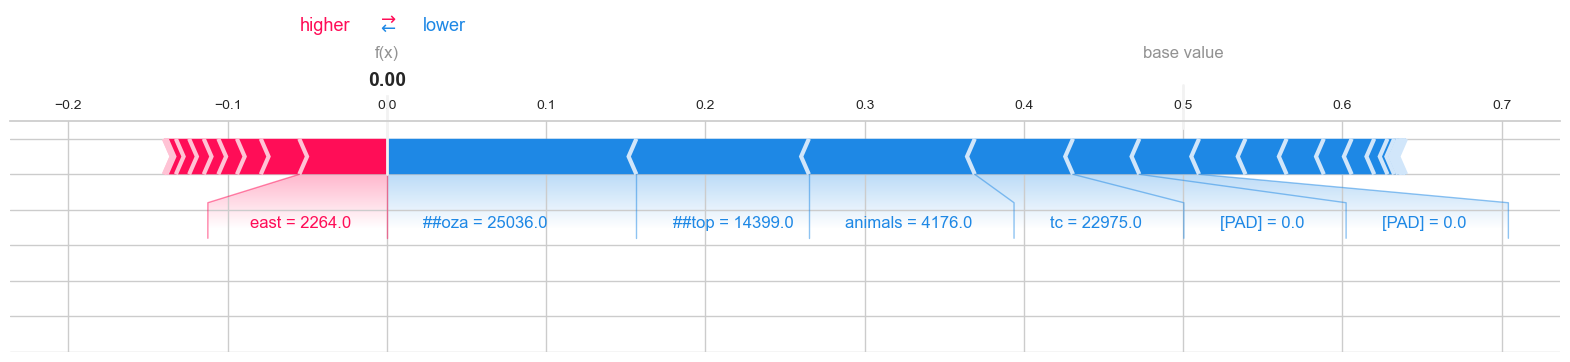

Sentence: 18 speed kent ladies mo ##uta ##in bike dual suspension 6000 tc ##ota ##q ##mu ##g ##wr ; Prediction: [0] ; True value: b'not_relevant'


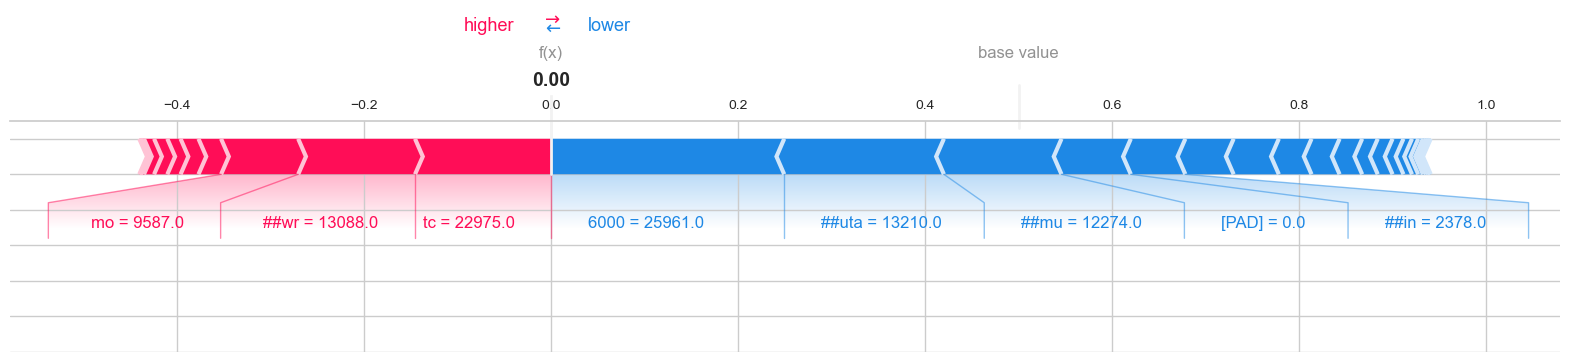

Sentence: breaking news major flood peak hit grafton flood waters continue rise queensland ex tropical cy ##cl ##o tc ##of ##j ##j ##b ##q ##t ##2 ##j ; Prediction: [0] ; True value: b'relevant'


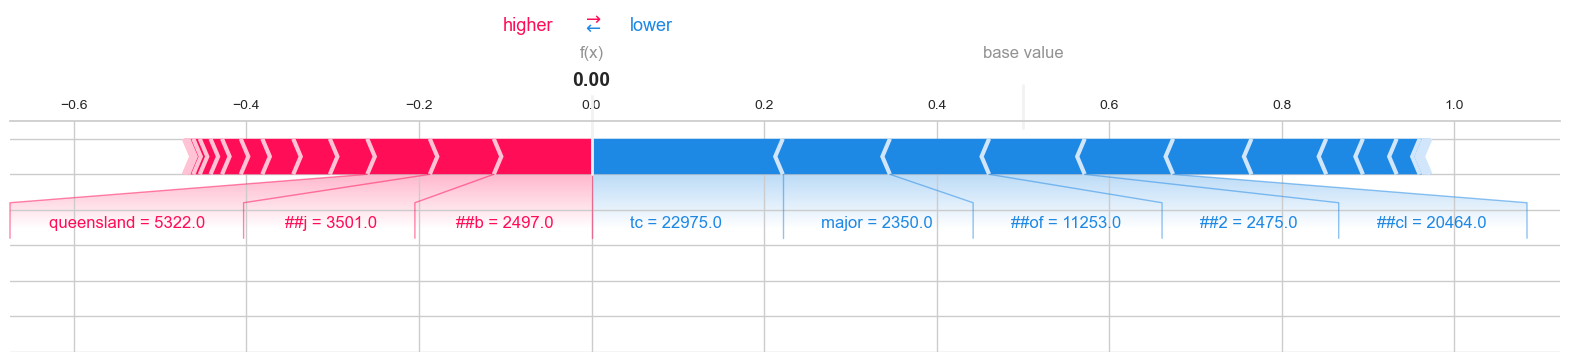

Sentence: dance year deal 25 unlimited classes week ; Prediction: [1] ; True value: b'not_relevant'


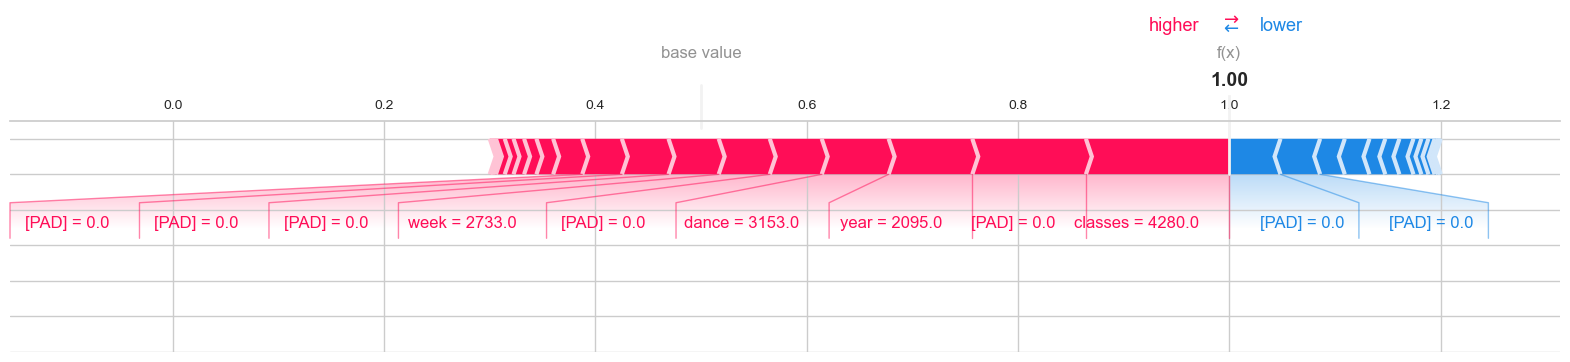

Sentence: sight australia flood victims brisbane risk running drinking water tc ##o ##1 ##yan ##w ##v ##v ##1 connect ; Prediction: [0] ; True value: b'relevant'


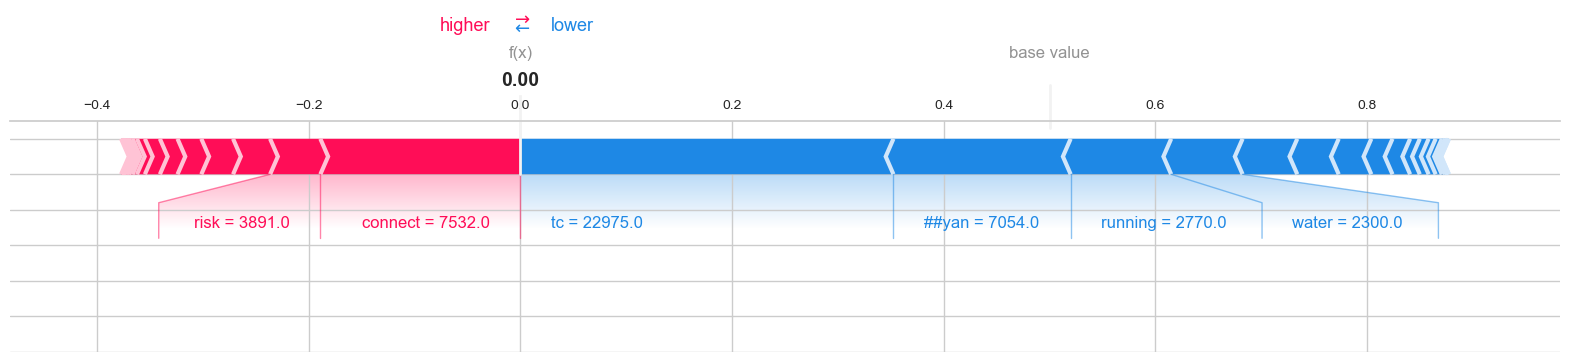

Sentence: mp red faced t ##wee ##t coalition mp suggests pm ignored flood stricken queensland pm touring bush ##fi ##r ; Prediction: [1] ; True value: b'relevant'


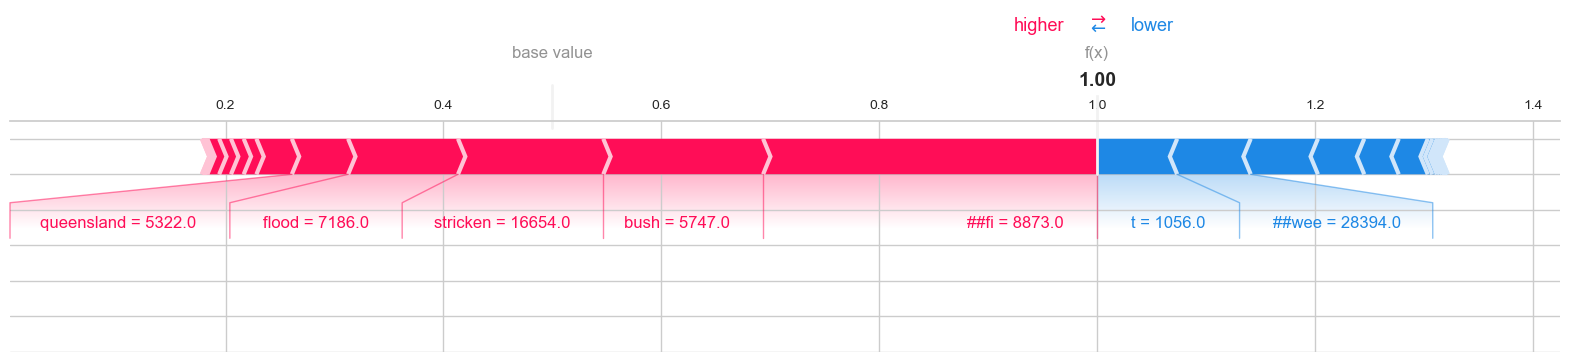

Sentence: catch ups brooklyn brisbane reunion beacon brewing co tc ##o ##q ##mb ##x ##olf ##6 ; Prediction: [1] ; True value: b'not_relevant'


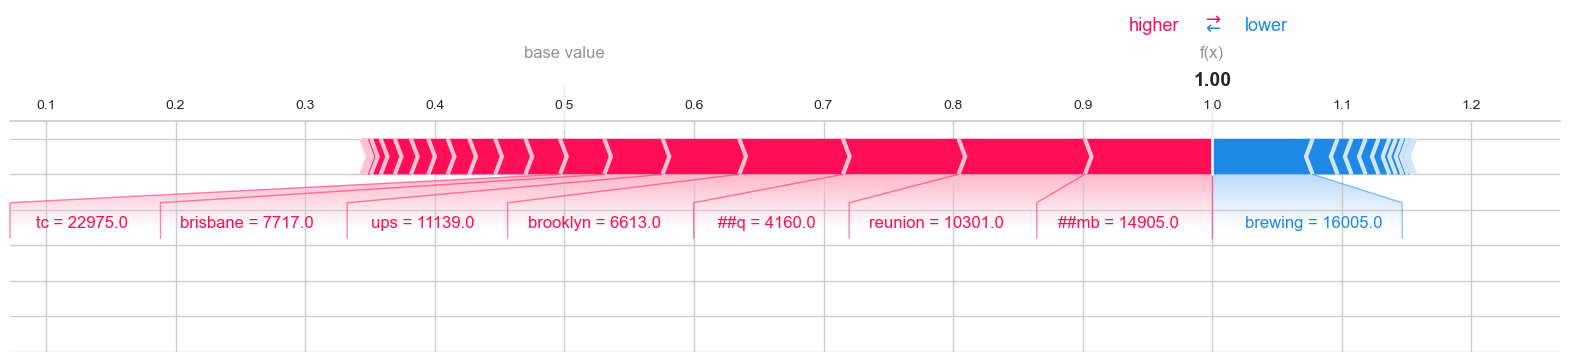

Sentence: wish explained dress code dressed ; Prediction: [1] ; True value: b'not_relevant'


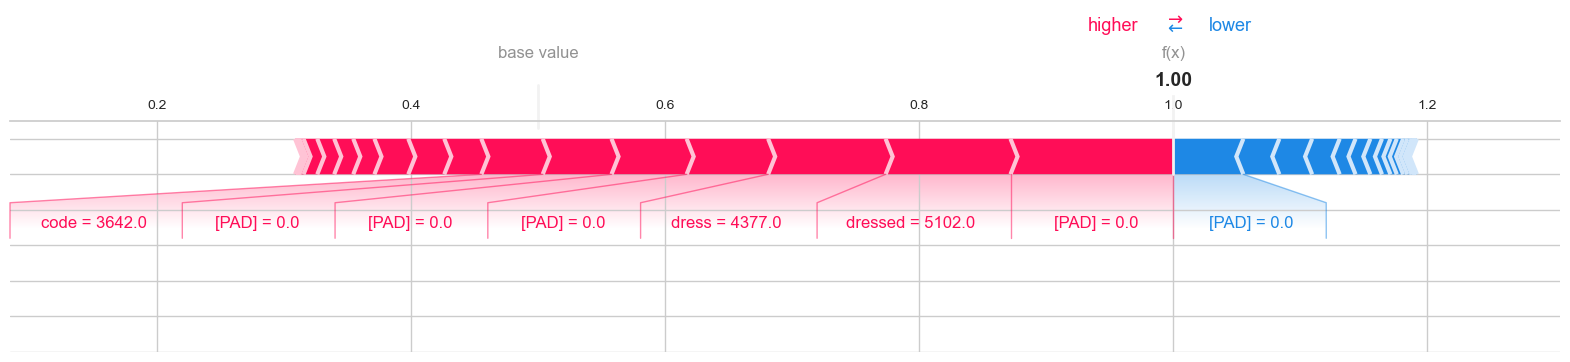

Sentence: national dead q ##ld flood crisis continues died queensland s floods danger ##o tc ##o ##53 ##wc ##bi ##8 ##w ; Prediction: [1] ; True value: b'relevant'


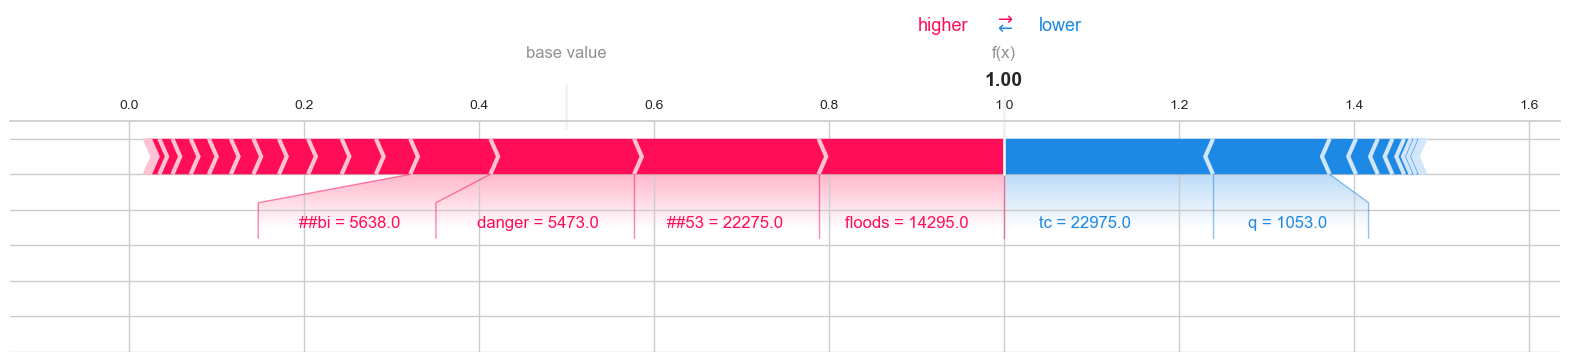

Sentence: s easy cheat body fuck s easy cheat relationships fuck ##ig adult ; Prediction: [1] ; True value: b'not_relevant'


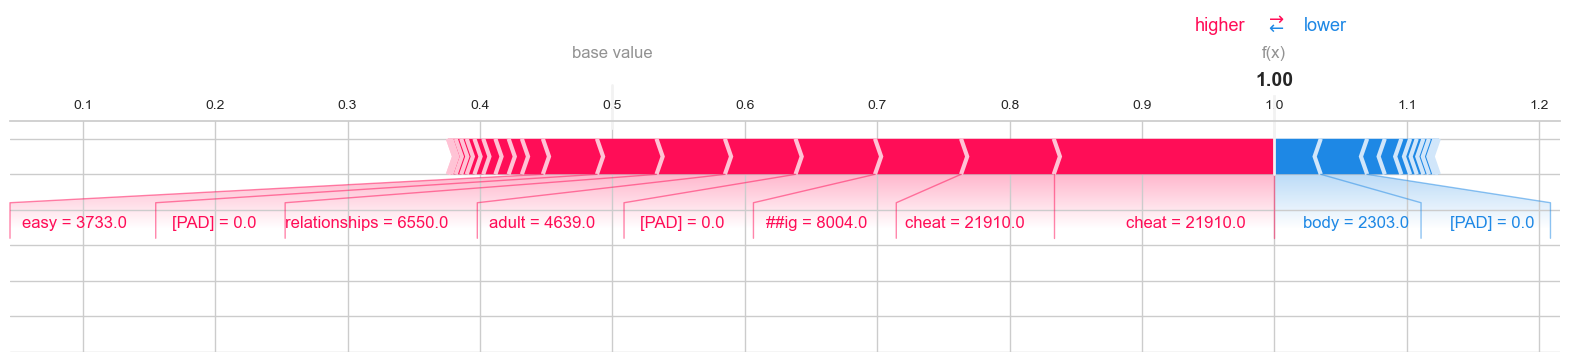

Sentence: played gr ##ump ##y played ; Prediction: [1] ; True value: b'not_relevant'


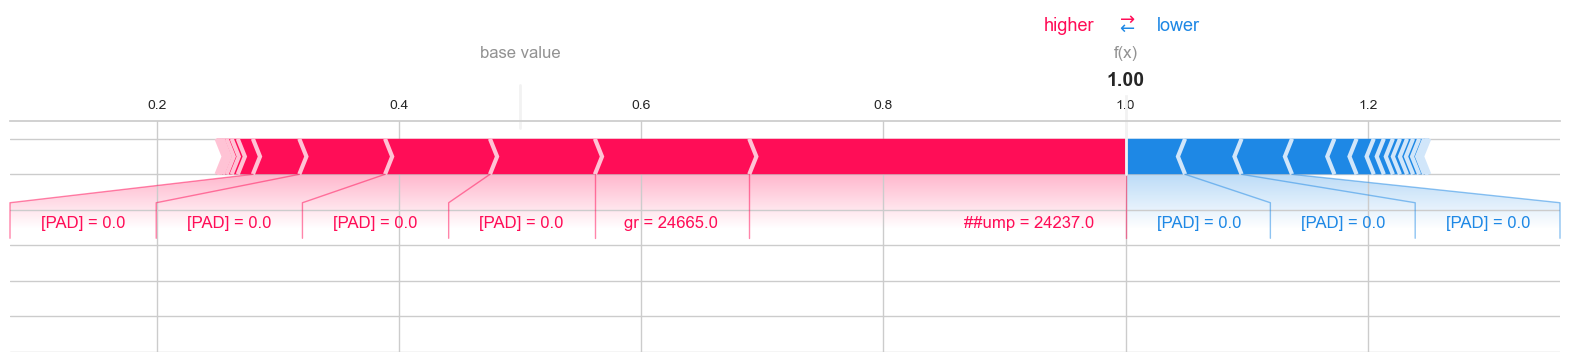

Sentence: follow appreciated love ; Prediction: [0] ; True value: b'not_relevant'


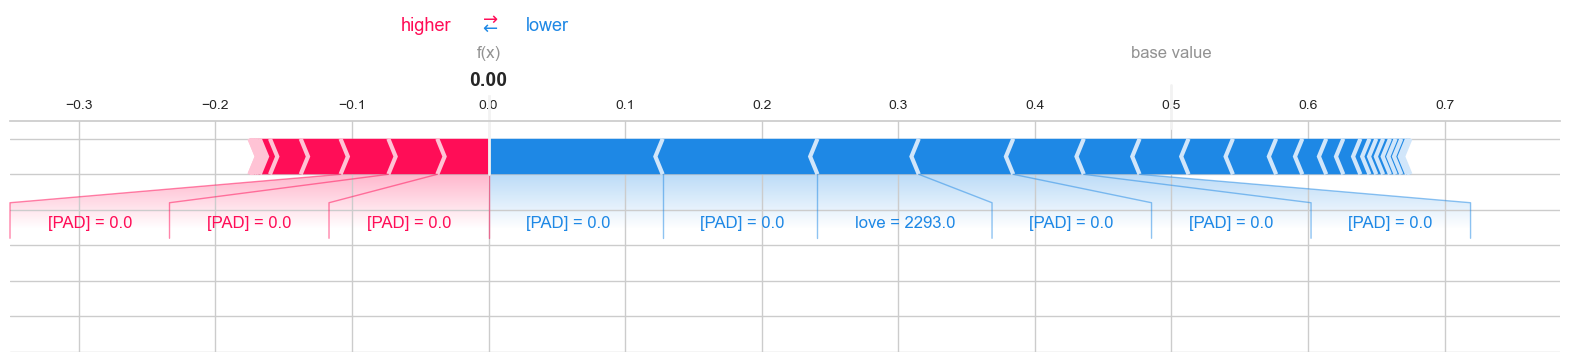

Sentence: stunning queensland flood pictures space tc ##ol ##md ##k ##b ##ge ##m ; Prediction: [1] ; True value: b'relevant'


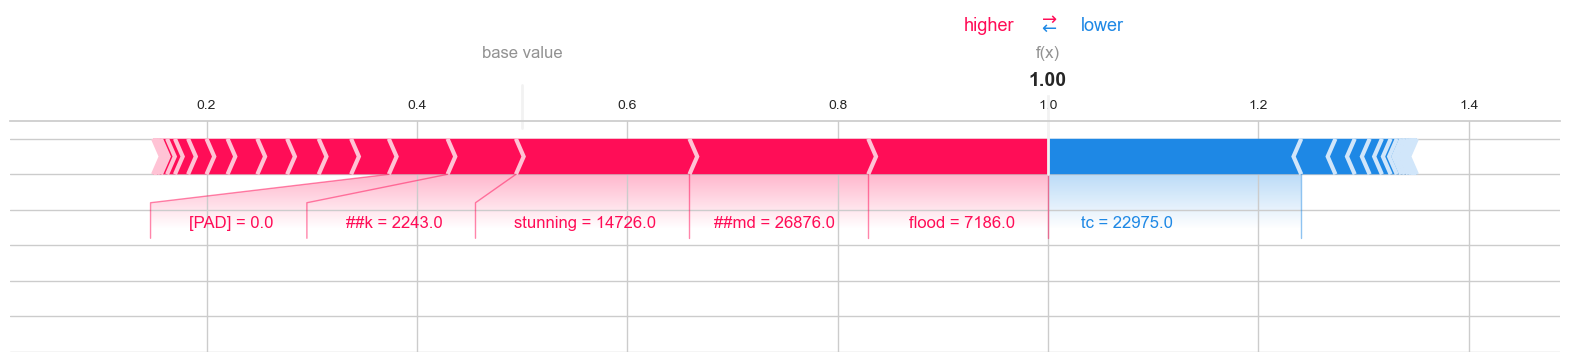

Sentence: grill d anymore post office feel sc ##um worthless shit ; Prediction: [1] ; True value: b'not_relevant'


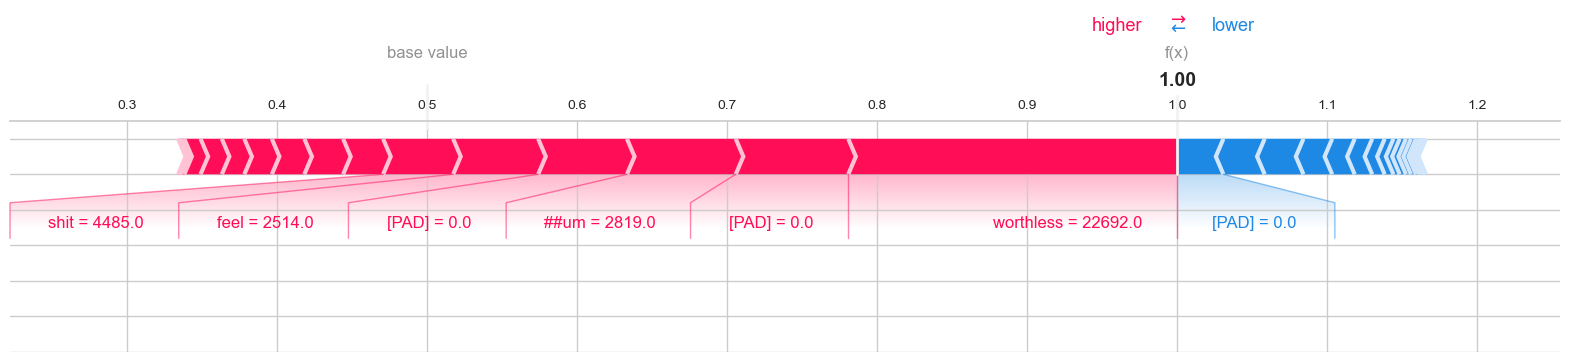

Sentence: australian government bureau meteor ##ology ##que ##ens ##land ##fl ##ood warning moon ##ie river ##iss ##ue ##d 65 ##6 pm tc ##o ##14 ##c ##7 ##j ##z ##8 ##j ; Prediction: [1] ; True value: b'relevant'


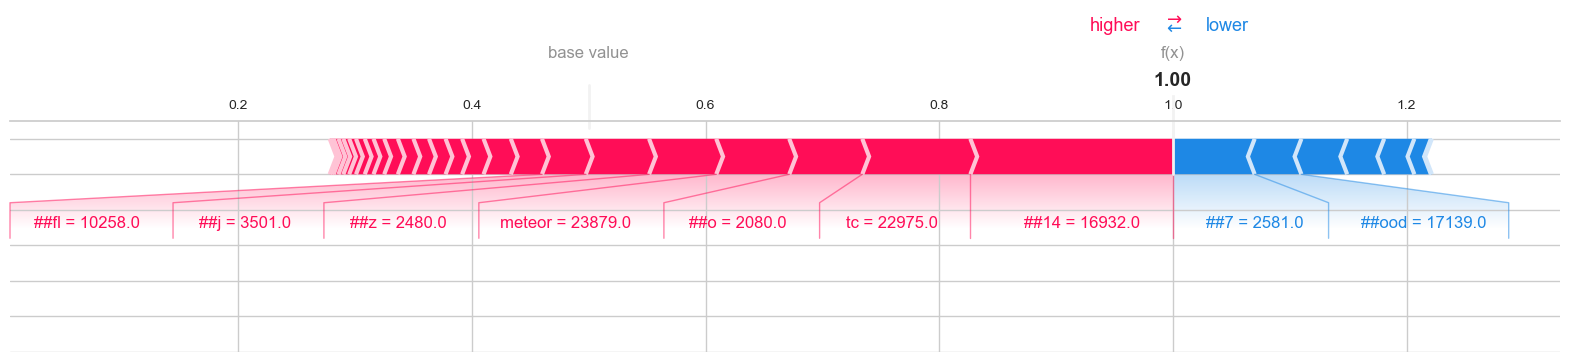

Sentence: s house damage insurance flood australia ; Prediction: [0] ; True value: b'relevant'


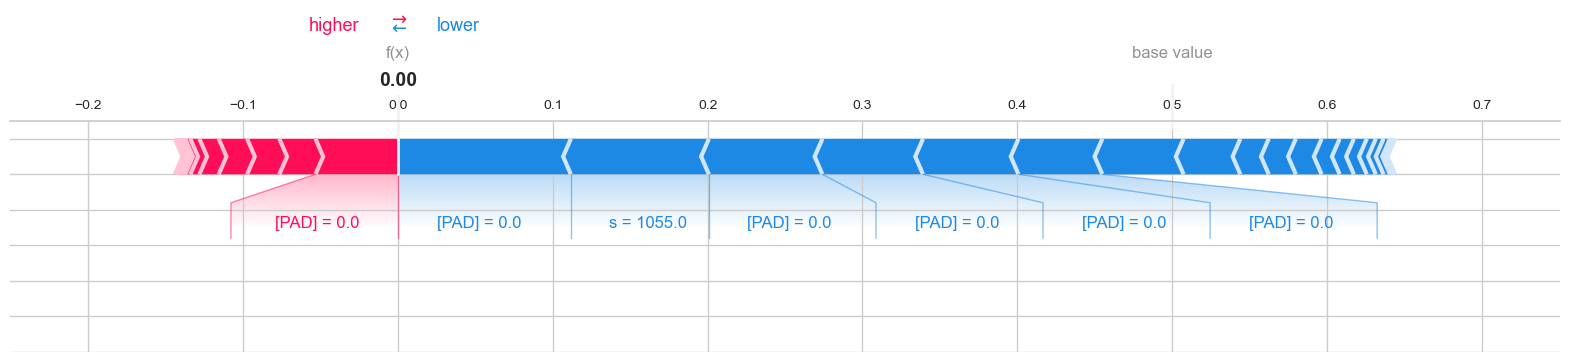

Sentence: follow appreciated love ; Prediction: [0] ; True value: b'not_relevant'


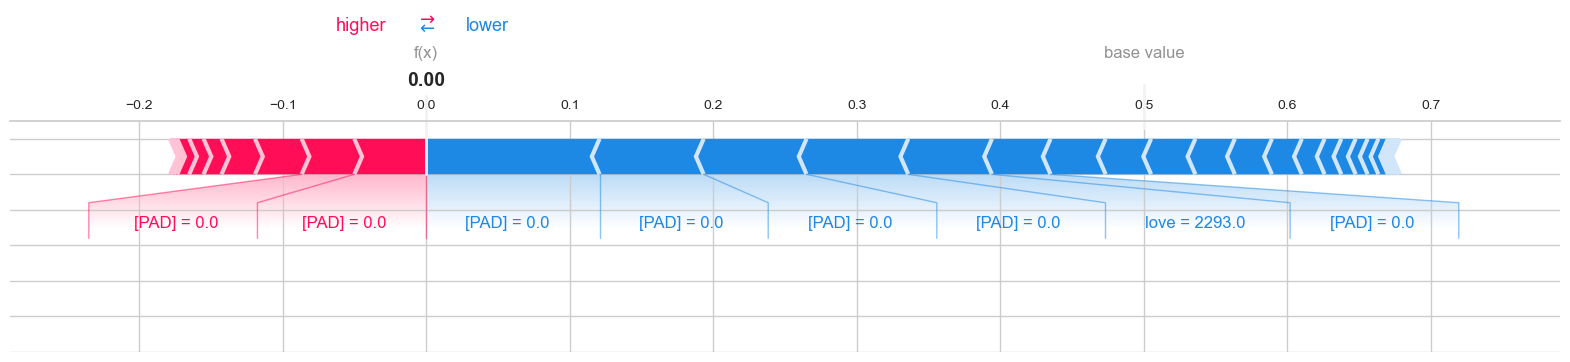

Sentence: deadly flood waters rise eastern australia tc ##og ##b ##j ##ja ##vo ##c ; Prediction: [1] ; True value: b'relevant'


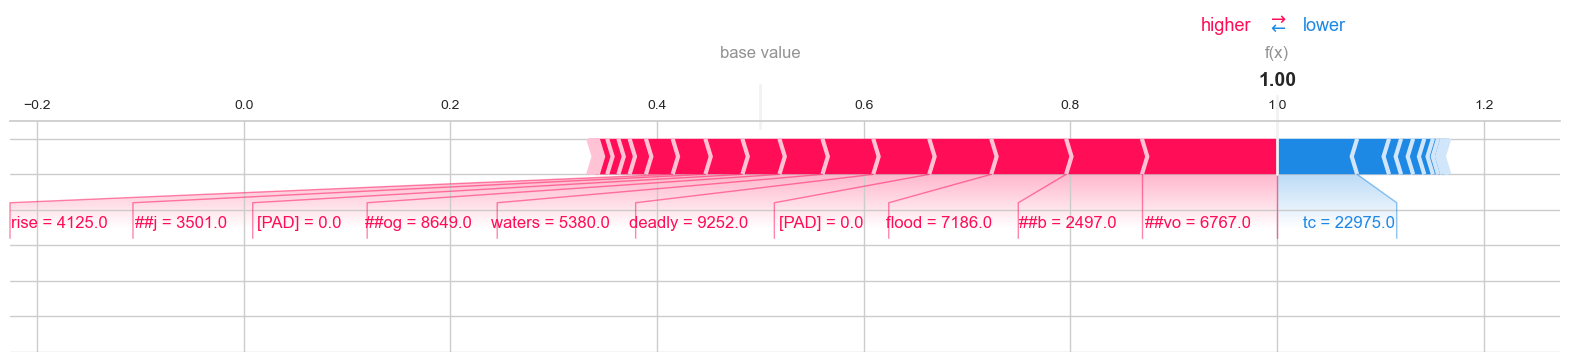

Sentence: prefer cr ##ayo ##ns markers ; Prediction: [0] ; True value: b'not_relevant'


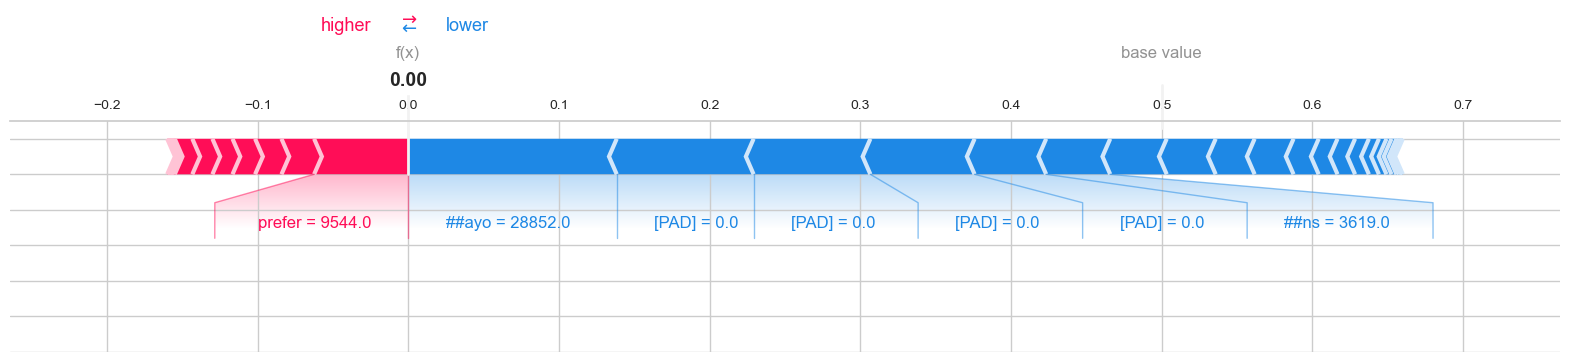

Sentence: happy birthday sweetie hope great day ; Prediction: [0] ; True value: b'not_relevant'


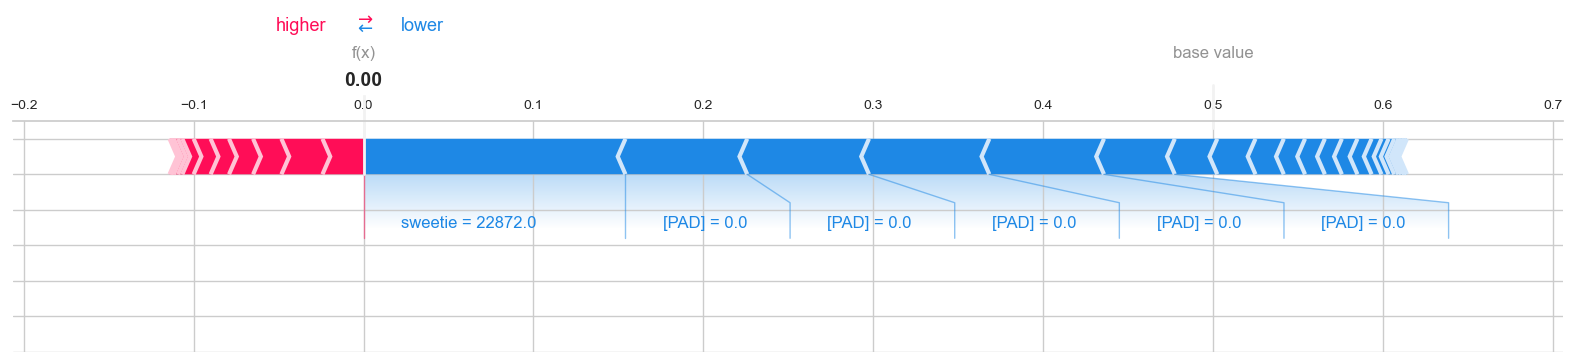

Sentence: queensland records flood death statewide catastrophe declared ; Prediction: [1] ; True value: b'relevant'


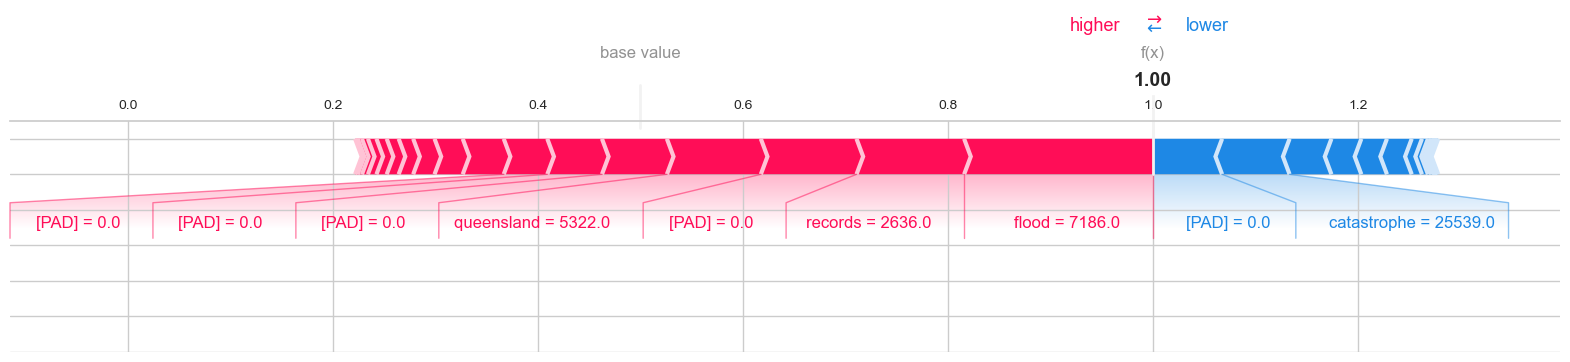

Sentence: nt ; Prediction: [0] ; True value: b'not_relevant'


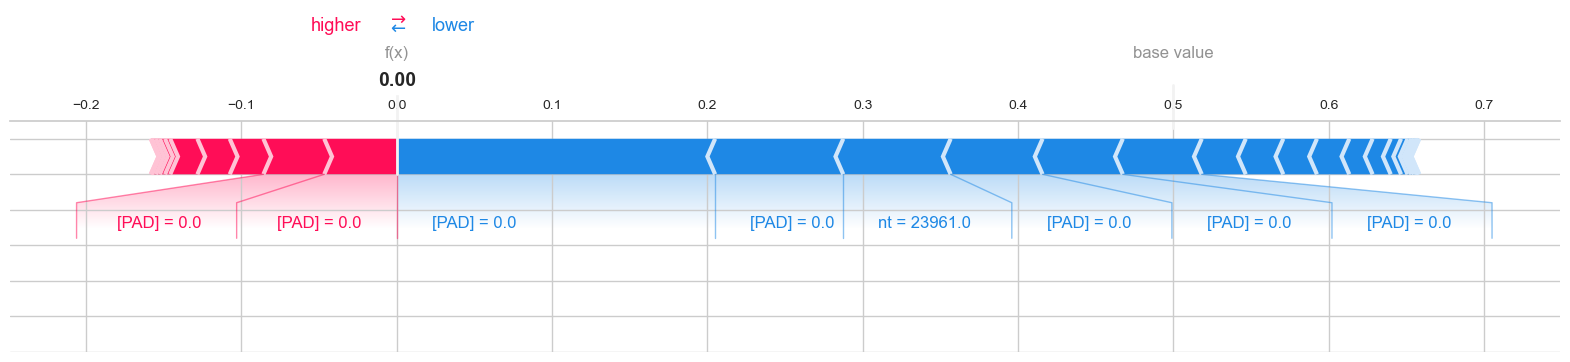

Sentence: top story south wales brace ##s river peaks queensland counts flood cost | \ x ##e ##2 \ x ##80 \ x ##a ##6 tc ##or ##8 ##b ##9 ##rad ##o tc ##ot ##p ##z ##b ##vc ##34 ; Prediction: [0] ; True value: b'relevant'


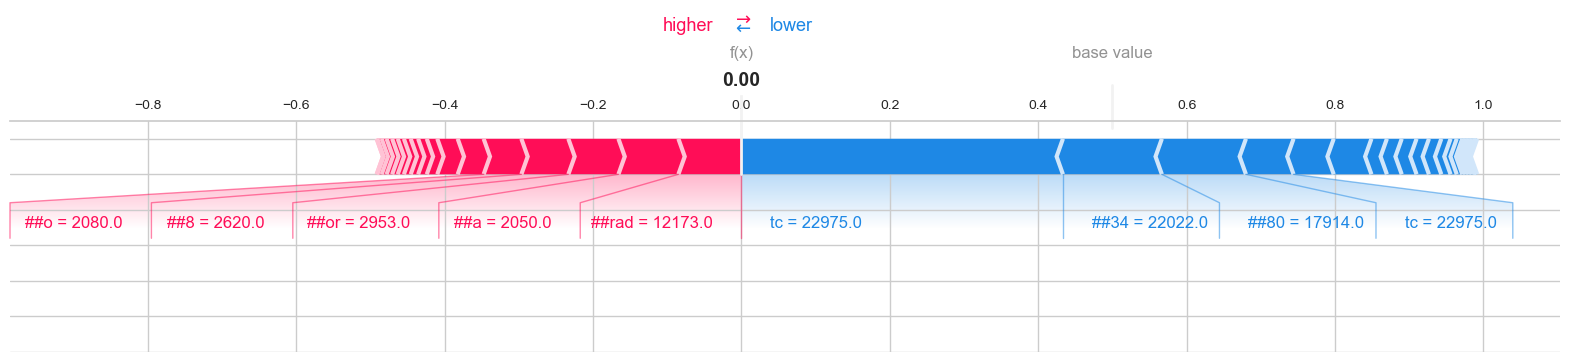

Sentence: re band ; Prediction: [0] ; True value: b'not_relevant'


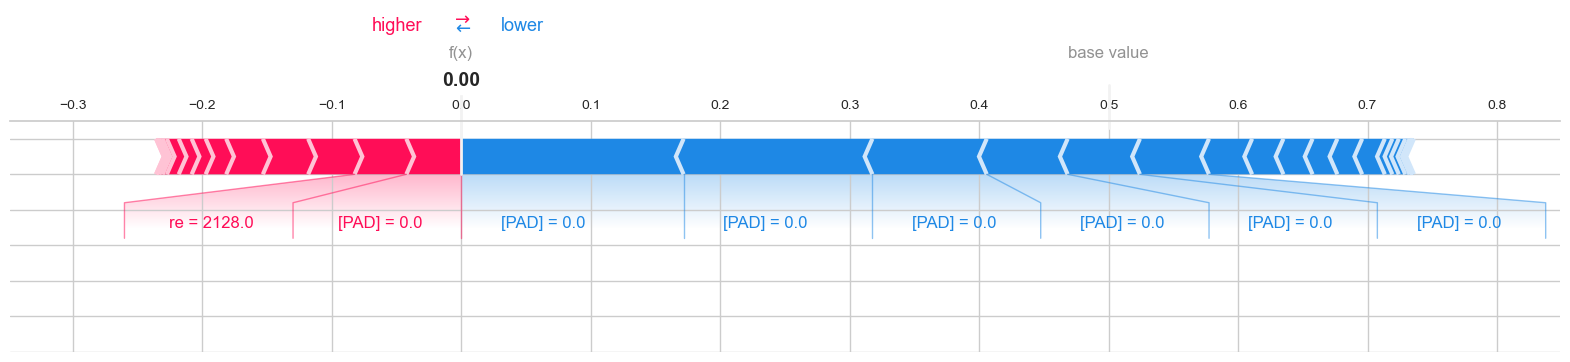

Sentence: 212 ft rain fell queensland australia yesterday major flood years ; Prediction: [1] ; True value: b'relevant'


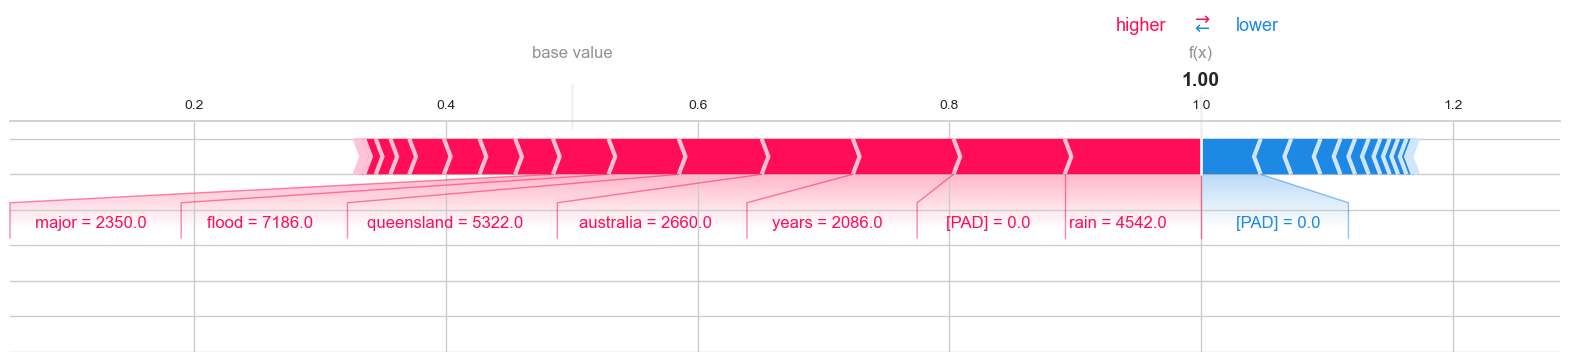

Sentence: email ale ##ys ##ham ##are ##e email ; Prediction: [1] ; True value: b'not_relevant'


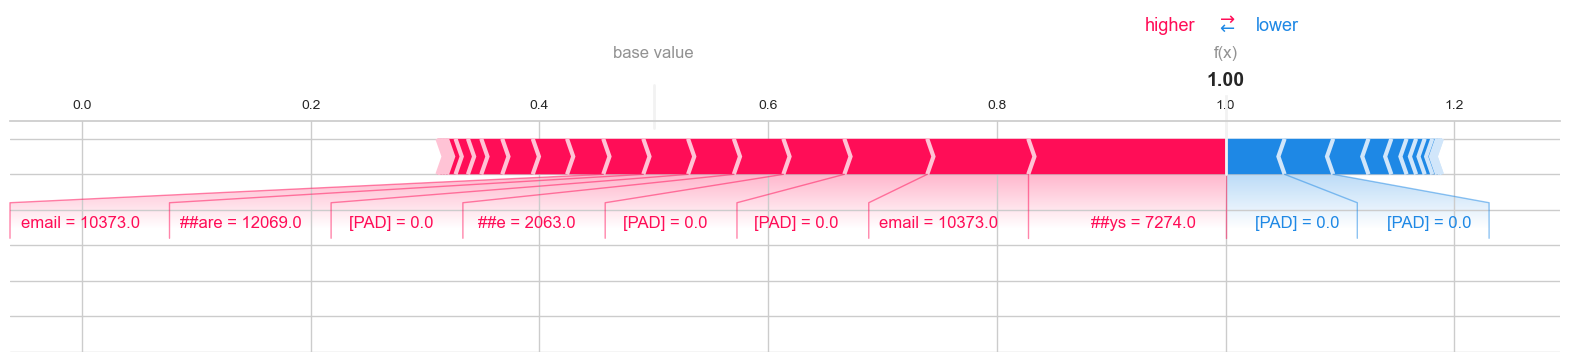

Sentence: sound ; Prediction: [0] ; True value: b'not_relevant'


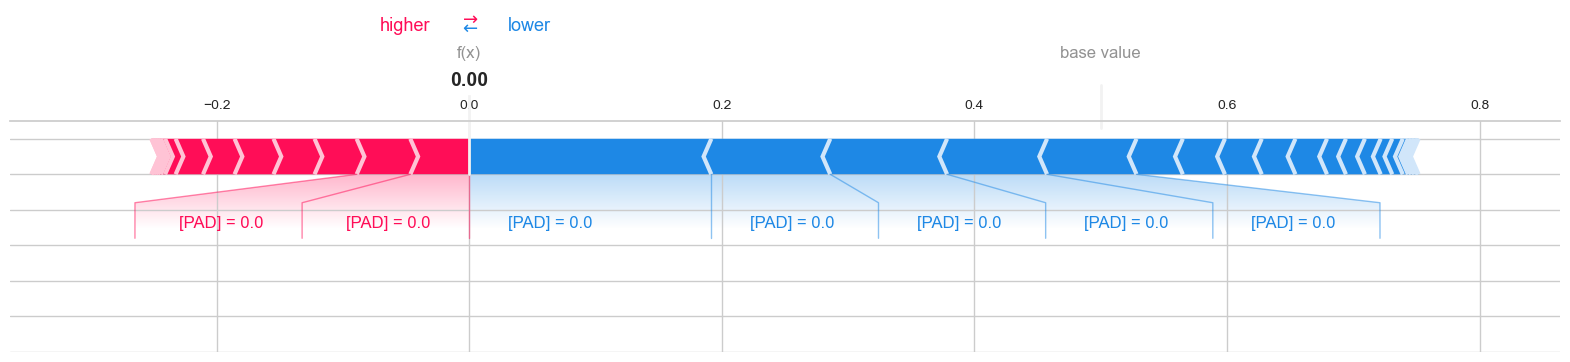

Sentence: s correct lets hope embarrassed retire ##s ; Prediction: [0] ; True value: b'not_relevant'


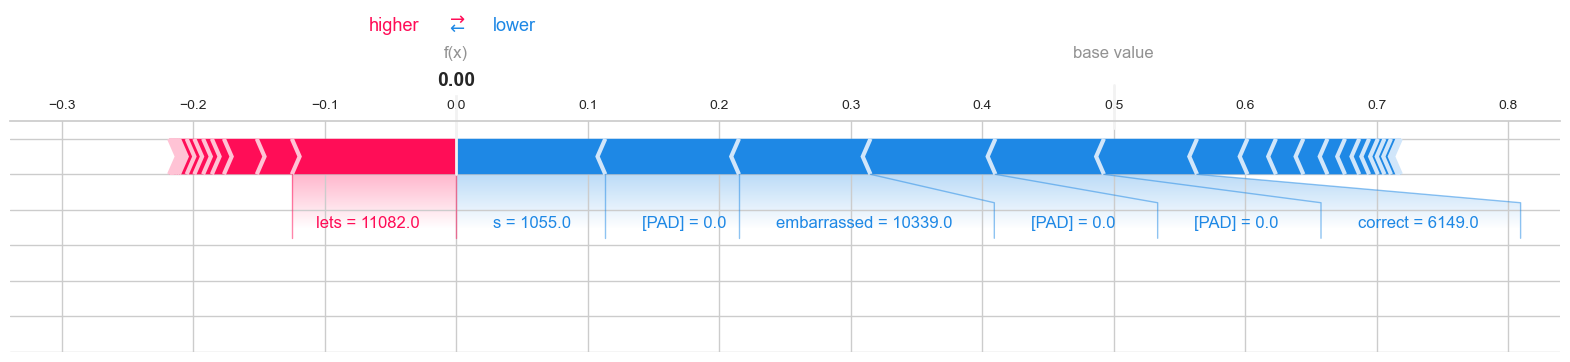

Sentence: body flood victim found police found body queensland s flood victim car tc ##oke ##k ##fm ##fs ##u ; Prediction: [1] ; True value: b'relevant'


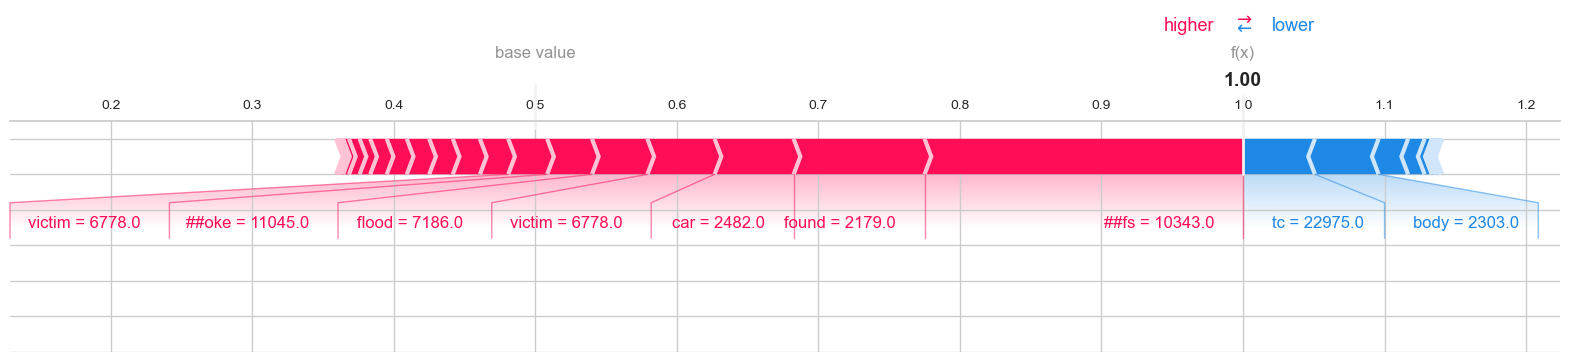

Sentence: queensland counts flood cost south wales brace ##s river peaks deaths confirmed fr tc ##ob ##w ##z ##su ##x ##vb team ##fo ##llo ##w ##back ; Prediction: [0] ; True value: b'relevant'


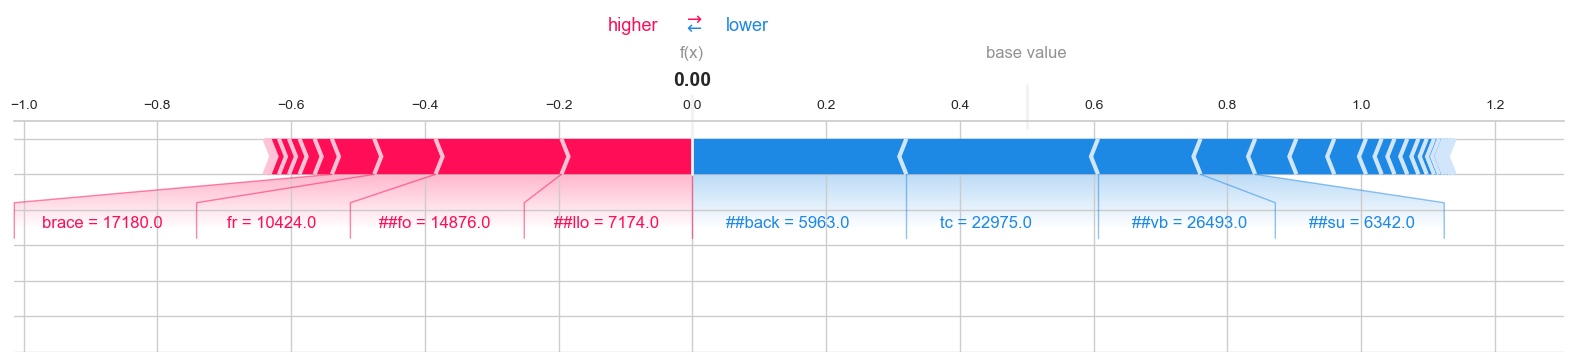

Sentence: gorgeous bu ##b tc ##on ##bm ##2 ##at ##j ##c ; Prediction: [0] ; True value: b'not_relevant'


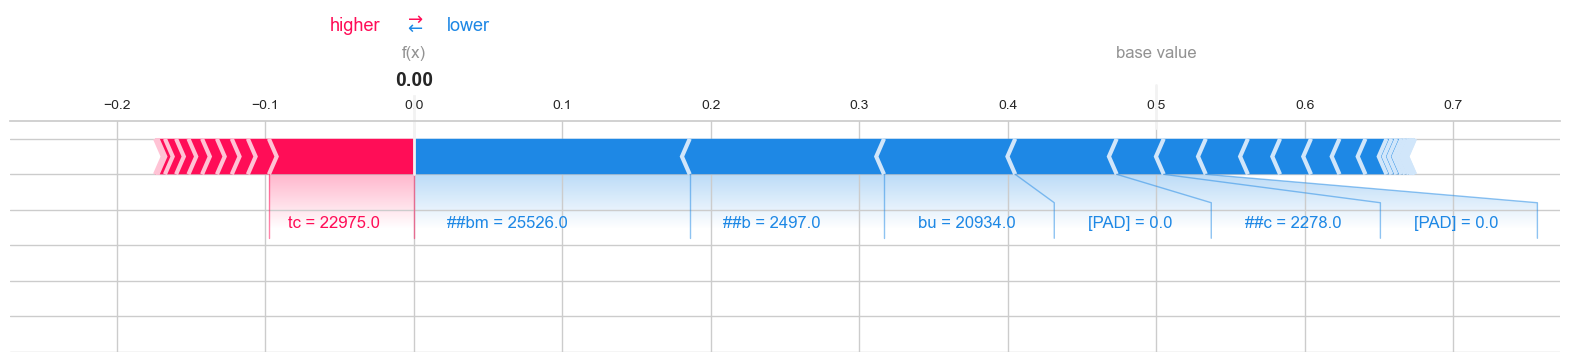

Sentence: school ; Prediction: [0] ; True value: b'not_relevant'


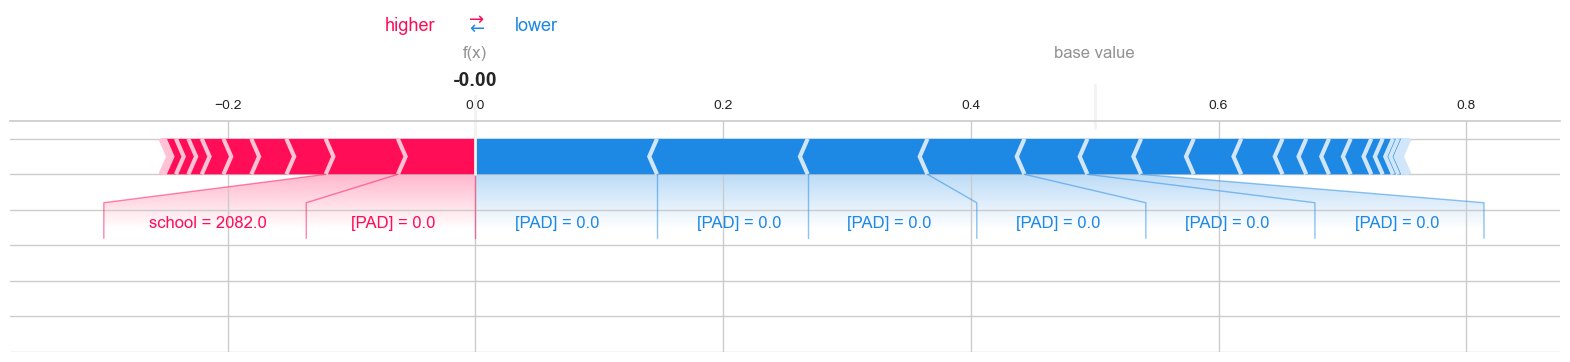

Sentence: dead dozens plucked roofs maroon ##ed cars air rescues northeastern australia severe flood ; Prediction: [1] ; True value: b'relevant'


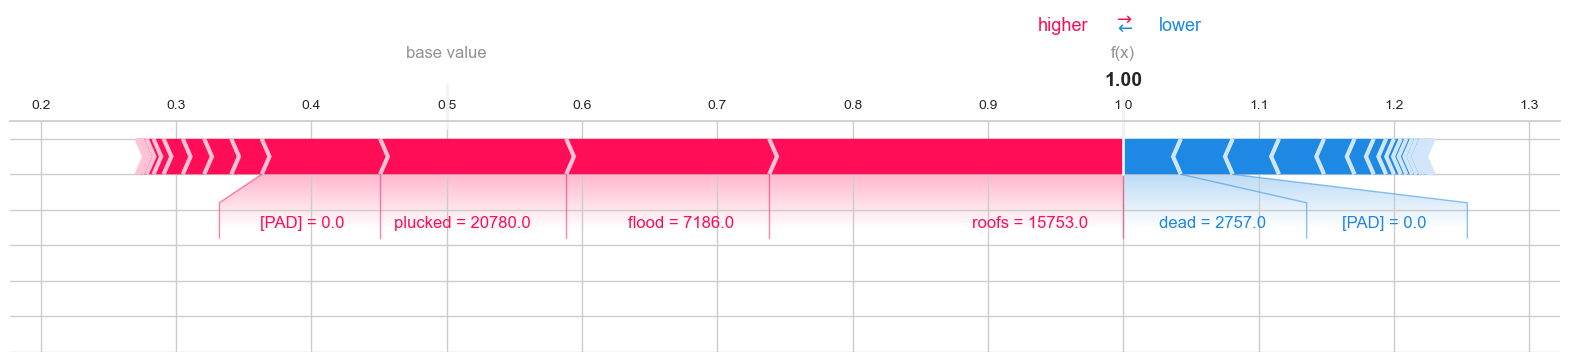

Sentence: om ##f ##g flooding streets unbelievable ; Prediction: [0] ; True value: b'relevant'


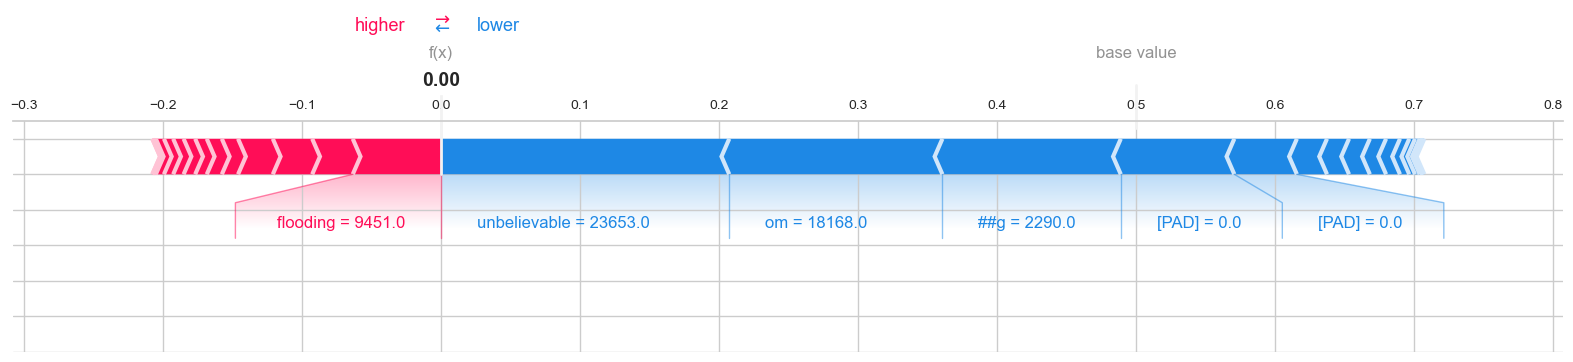

Sentence: brisbane brace ##s major queensland flood crisis un ##fold ##s tc ##o ##5 ##a ##9 ##pd ##ln ##d ; Prediction: [1] ; True value: b'relevant'


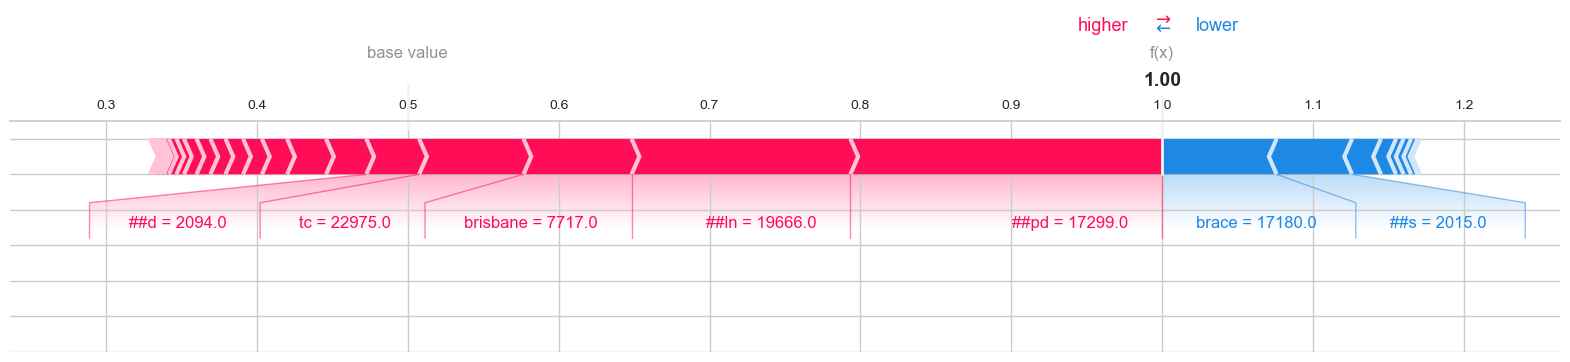

Sentence: top stories news queensland s flood crisis deep ##ens death toll rises australian tc ##oy ##3 ##gne ##ic ##p ; Prediction: [0] ; True value: b'relevant'


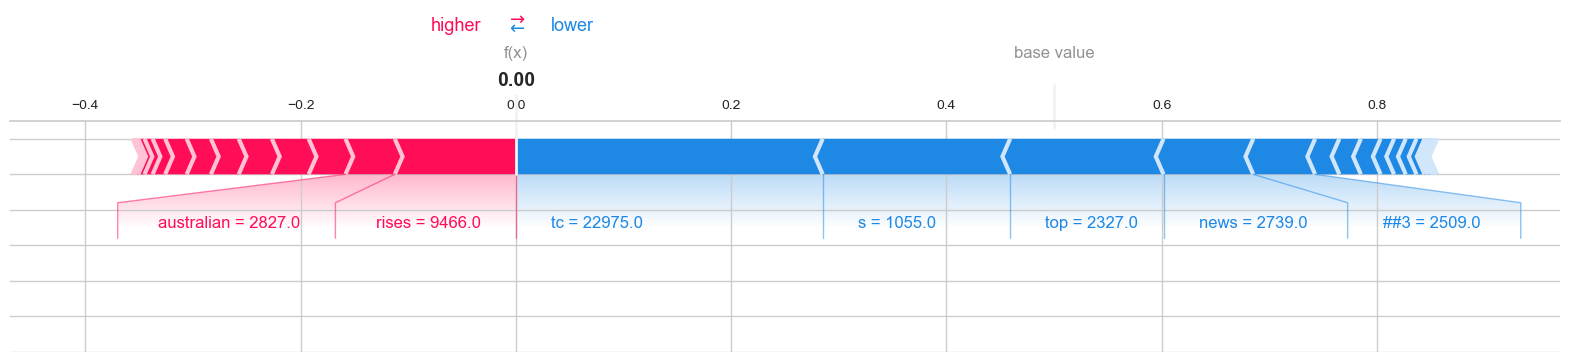

Sentence: asbestos threatens fire flood victims sky news australia tc ##oda ##ub ##v ##ku ##g ; Prediction: [1] ; True value: b'relevant'


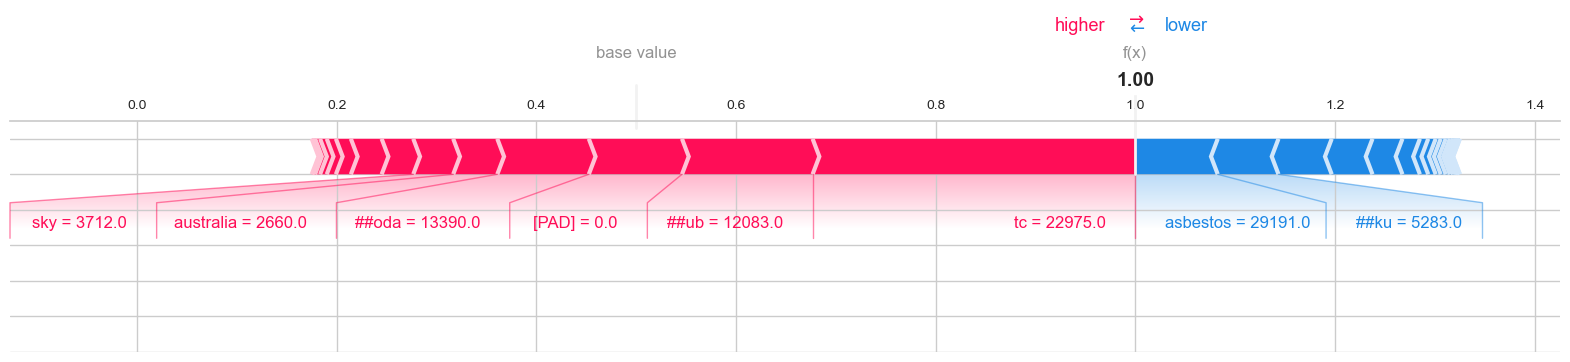

Sentence: go ##ggles flying wings ; Prediction: [0] ; True value: b'not_relevant'


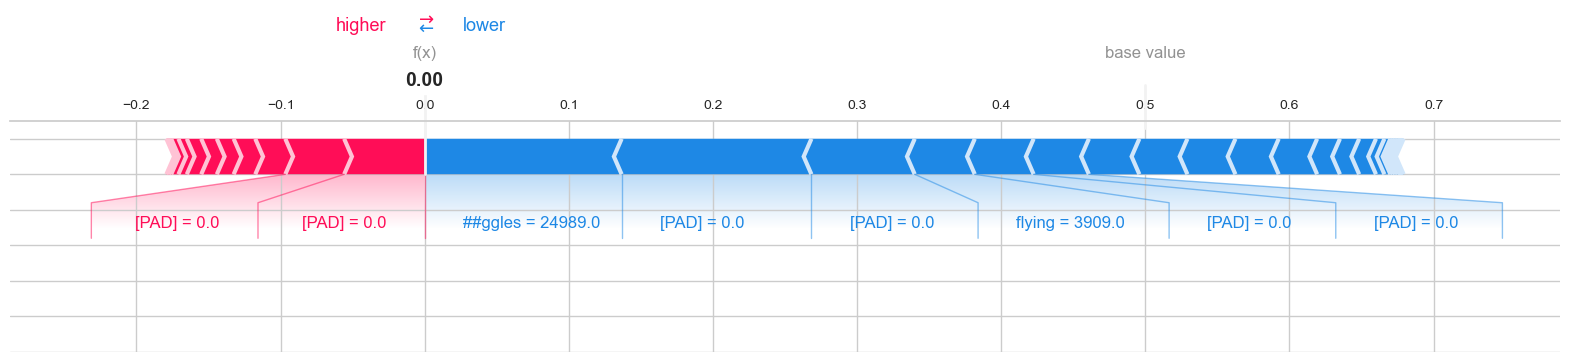

Sentence: south wales brace ##s river peaks queensland counts flood cost deaths confirmed torre ##ntial ra tc ##of ##h ##q ##4 ##ah ##mu ; Prediction: [1] ; True value: b'relevant'


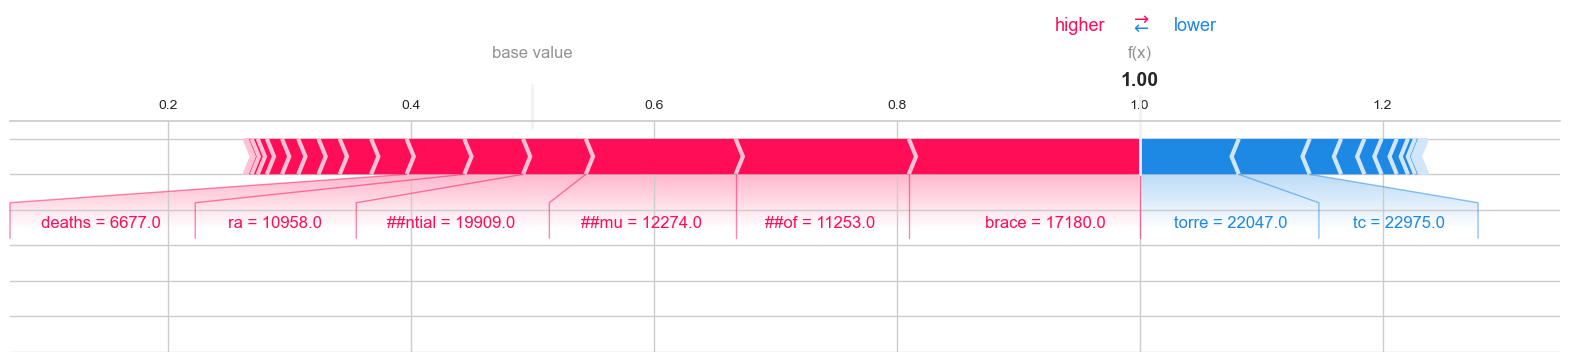

Sentence: praying queensland flood crises god waters nt swept away ; Prediction: [0] ; True value: b'relevant'


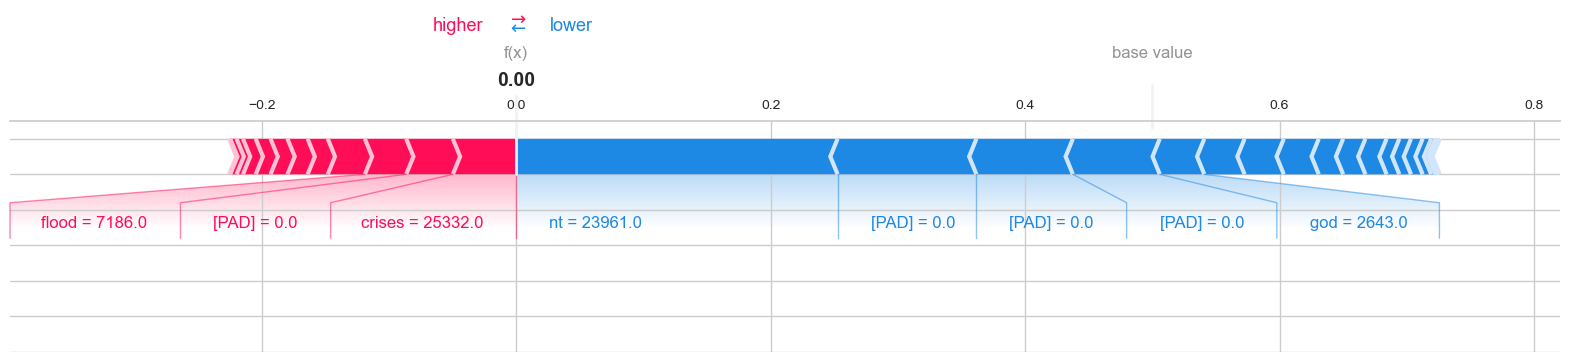

Sentence: q ##ld premier launches flood appeal queensland flood appeal launched premier kick start ##e tc ##og ##gr ##ui ##uz ##p ; Prediction: [1] ; True value: b'relevant'


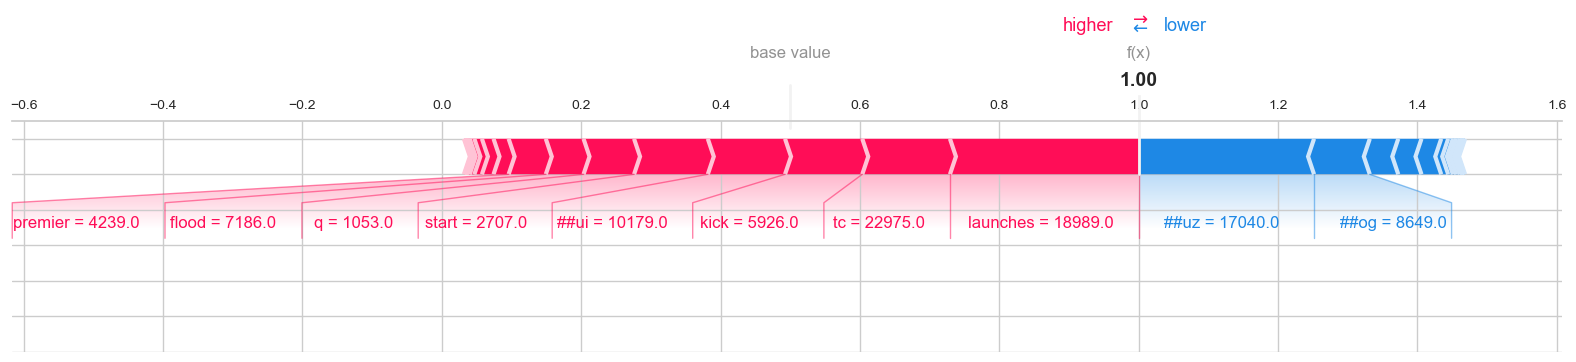

Sentence: sorry ding ##o train poor reception present mobile range ; Prediction: [0] ; True value: b'not_relevant'


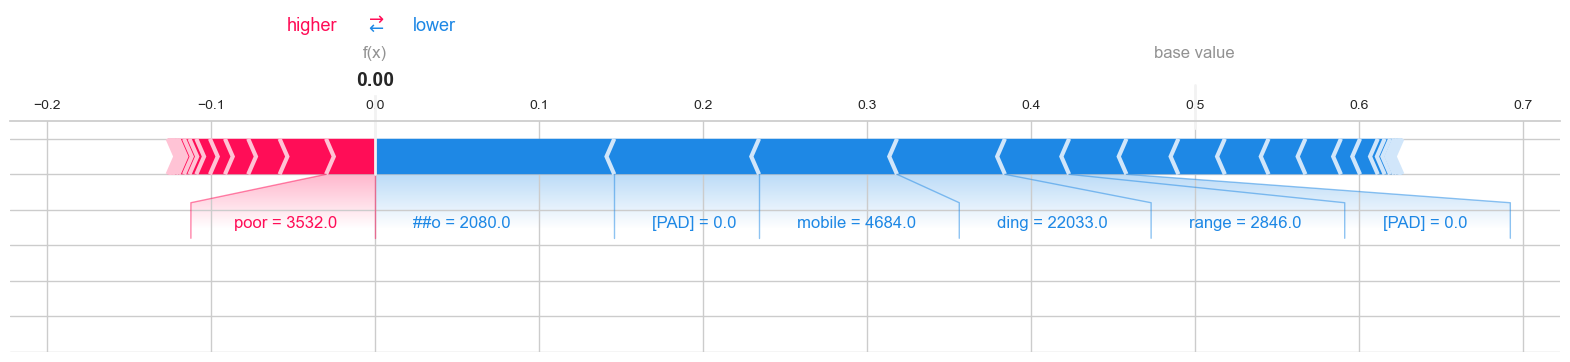

Sentence: australia s flood crisis worse ##ns death toll rises tc ##oa ##1 ##nr ##sb ##jk ; Prediction: [0] ; True value: b'relevant'


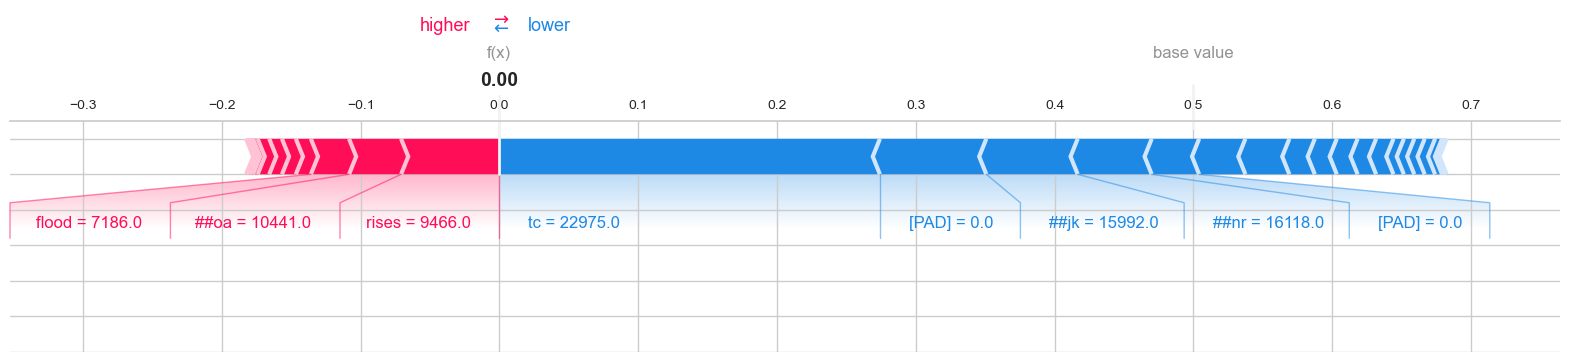

Sentence: o ##oh 1000 ##th follower term follower slightly creepy res ##erving ##ju ##dge ##ment ; Prediction: [1] ; True value: b'not_relevant'


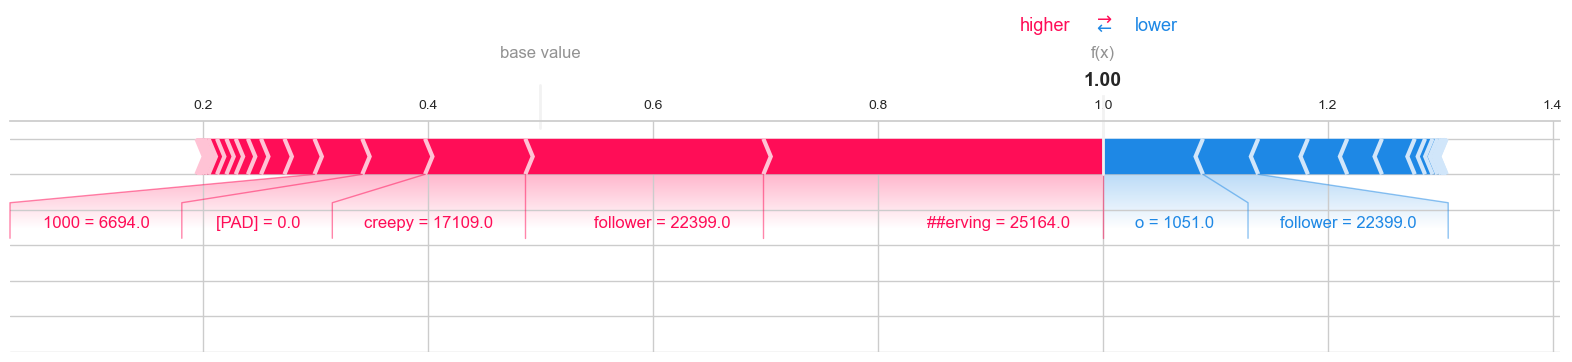

Sentence: miss ; Prediction: [0] ; True value: b'not_relevant'


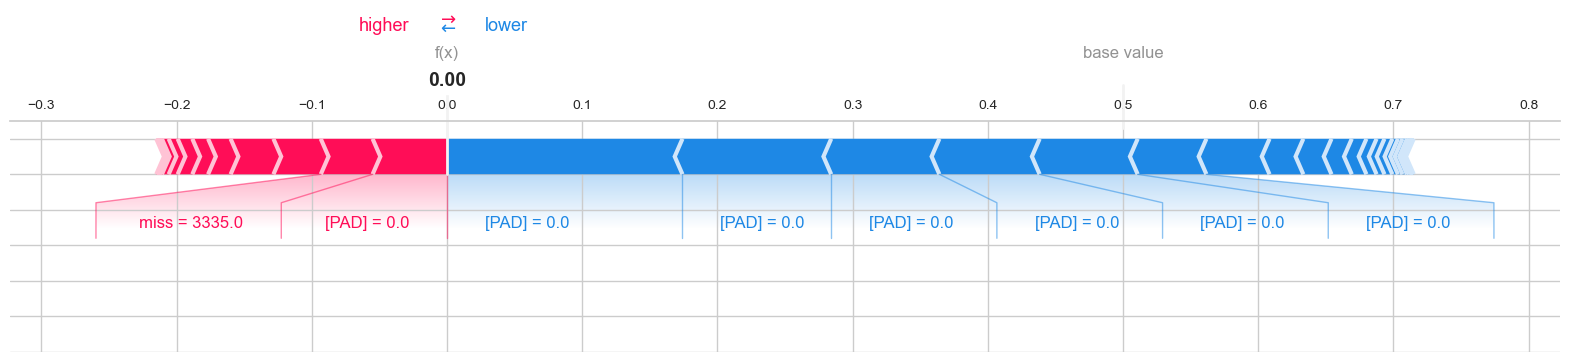

Sentence: tony abbott labor seek queensland flood levy | australian tc ##ob ##dh ##hy ##c ##j ##t m go ##bs ##mack ##ed things idiot ; Prediction: [1] ; True value: b'relevant'


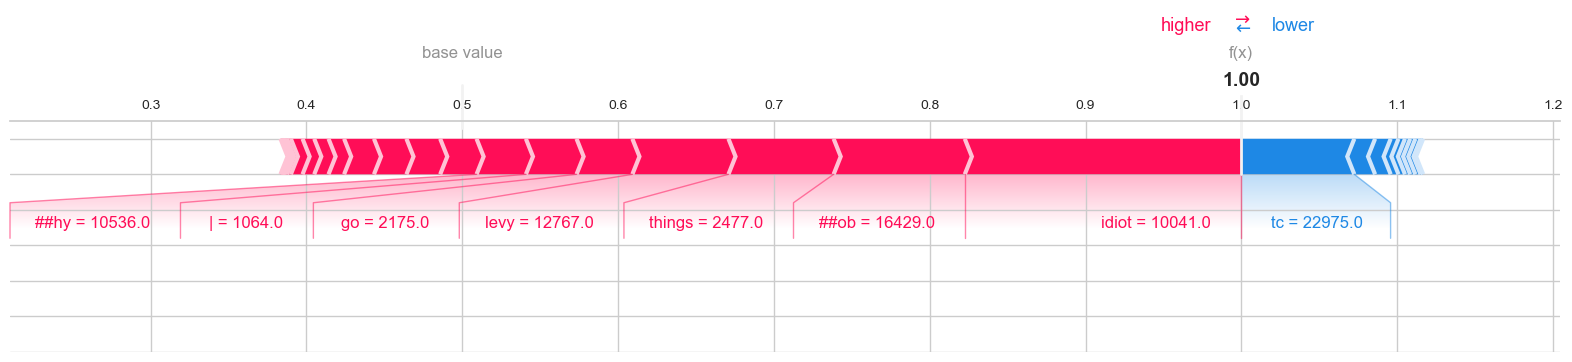

Sentence: m sun ##corp stadium brisbane roar vs central coast mariners milton q ##ld w 24 tc ##oot ##x ##47 ##j ##ct ; Prediction: [1] ; True value: b'not_relevant'


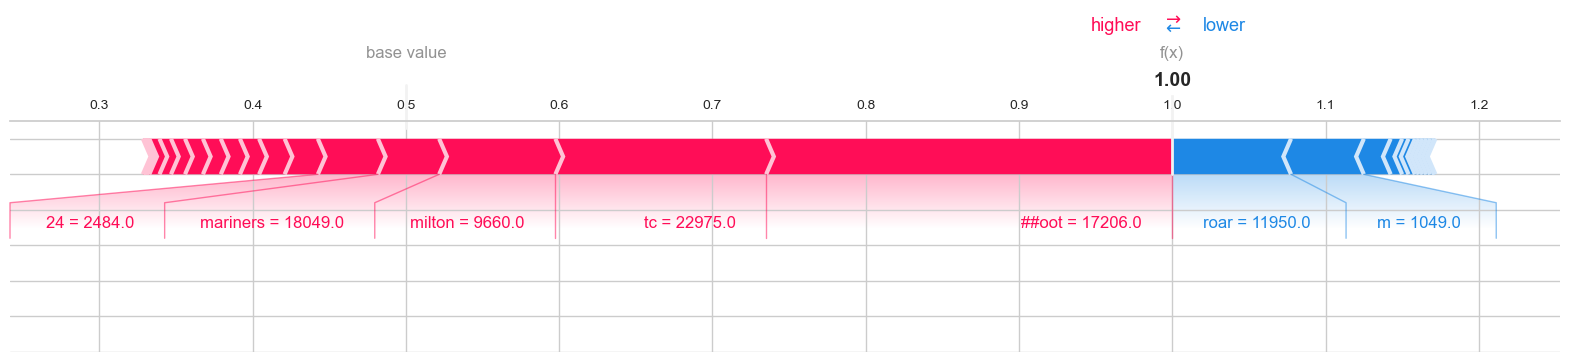

Sentence: climate change blamed australia lu ##rch ##es fire flood tc ##os ##z ##xt ##c ##w ##7 ##m extreme ##weather ; Prediction: [1] ; True value: b'relevant'


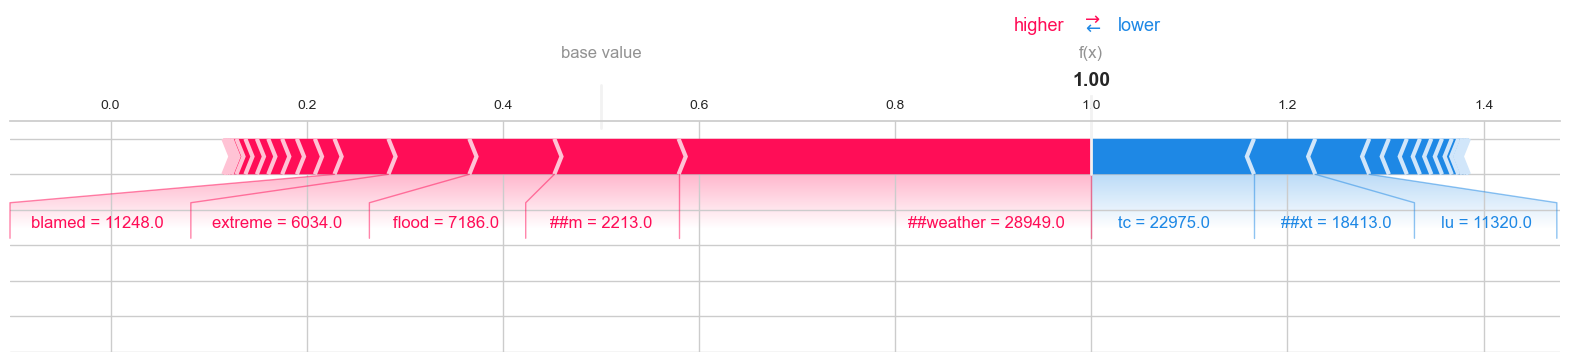

Sentence: traffic lights u ##gh ; Prediction: [0] ; True value: b'relevant'


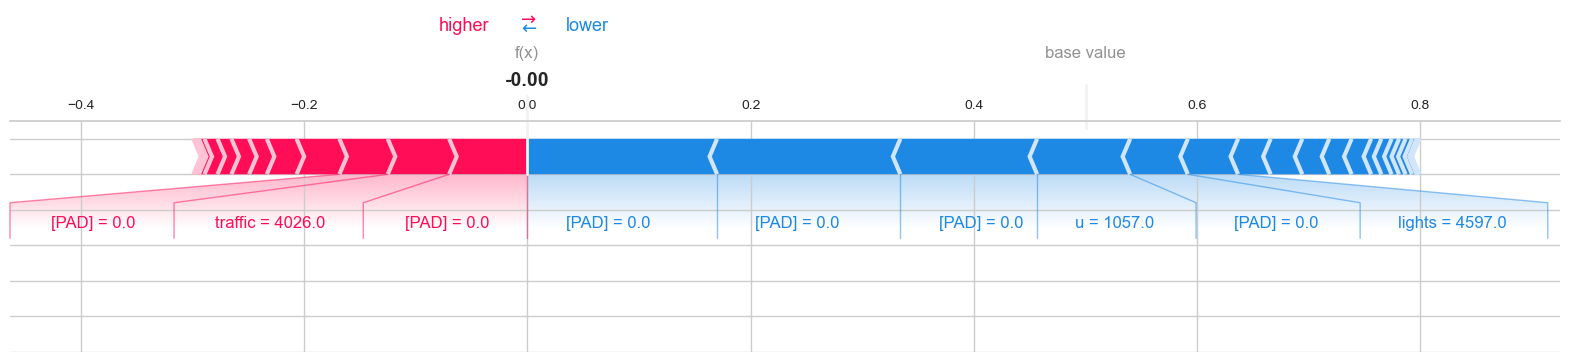

Sentence: girls gymnastics leo size 10 450 ##0 gil ##ston tc ##o ##4 ##d ##z ##v ##8 ##e ##6 ##g ; Prediction: [1] ; True value: b'not_relevant'


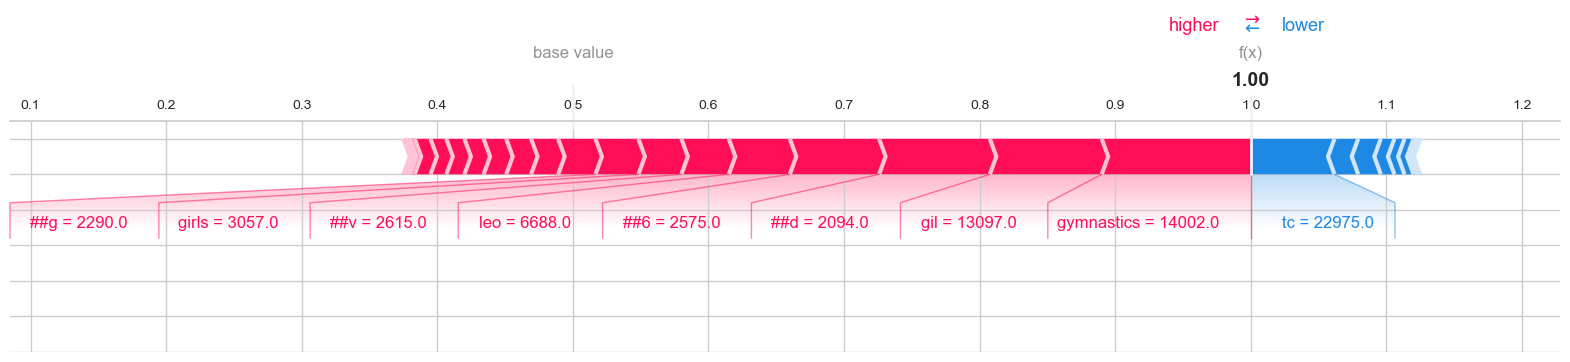

Sentence: executive assistant lai ##ng oro ##ur ##ke brisbane q ##ld innovative privately owned construction development tc ##ox ##py ##i ##6 ##cr ##c ; Prediction: [1] ; True value: b'not_relevant'


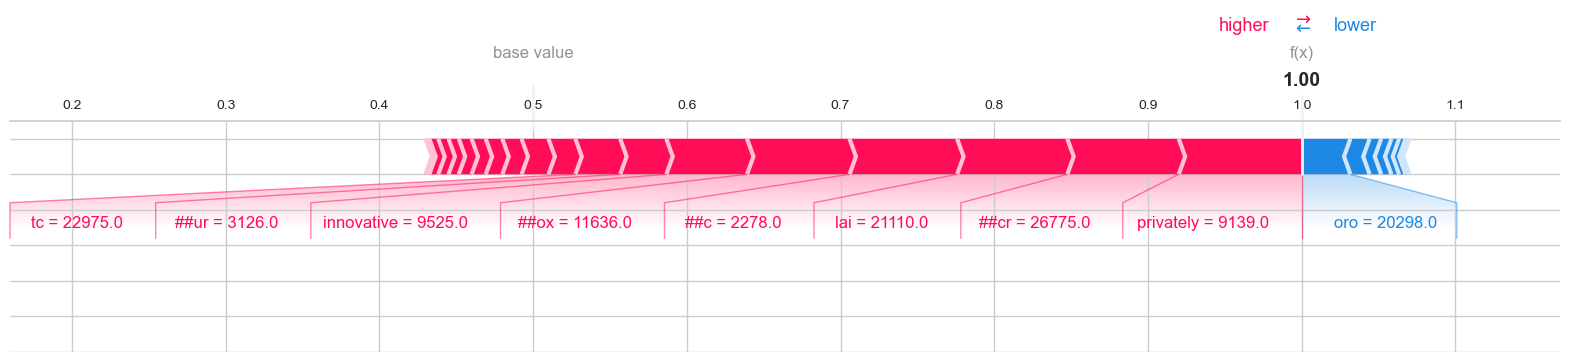

Sentence: donate red cross queensland flood appeal tc ##off ##p ##x ##ua ##xi call 1800 81 ##1 700 ; Prediction: [0] ; True value: b'relevant'


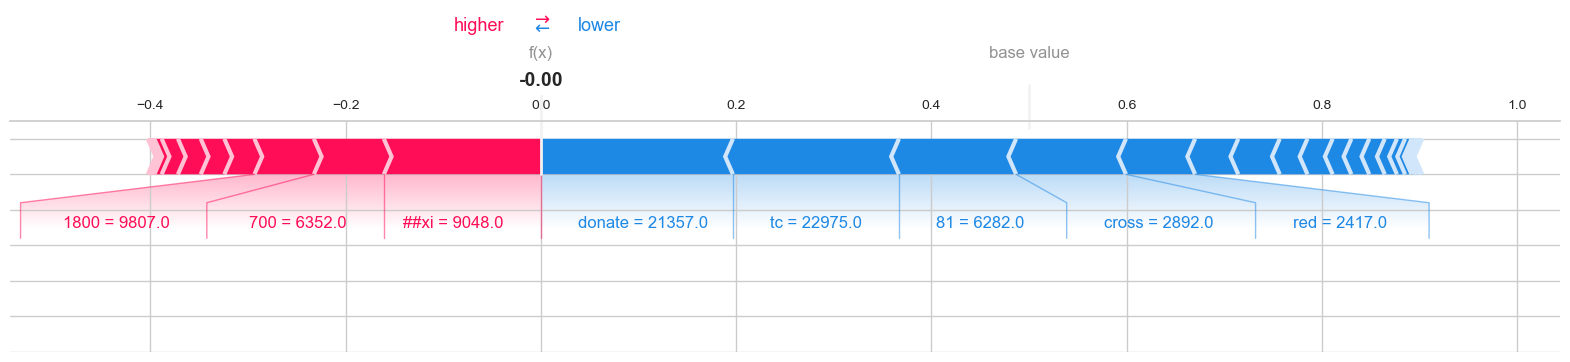

Sentence: om ##g reading posted night cha ##p ##17 ; Prediction: [0] ; True value: b'not_relevant'


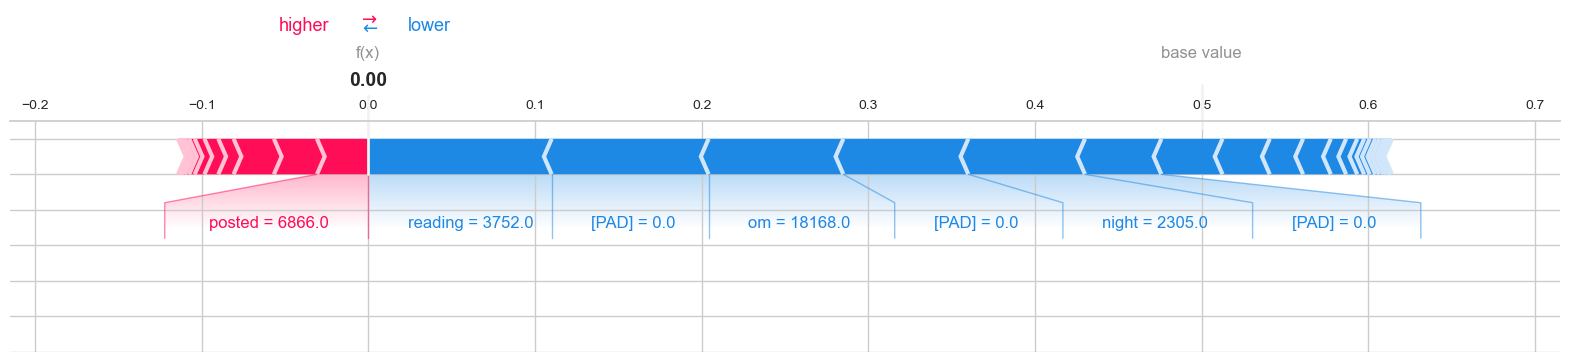

Sentence: s demand order pd ##rk stop ##nu ##cle ##arte ##sti ##ng stop lying bleeding non ##uc ##lea ##rte ##sts ; Prediction: [1] ; True value: b'not_relevant'


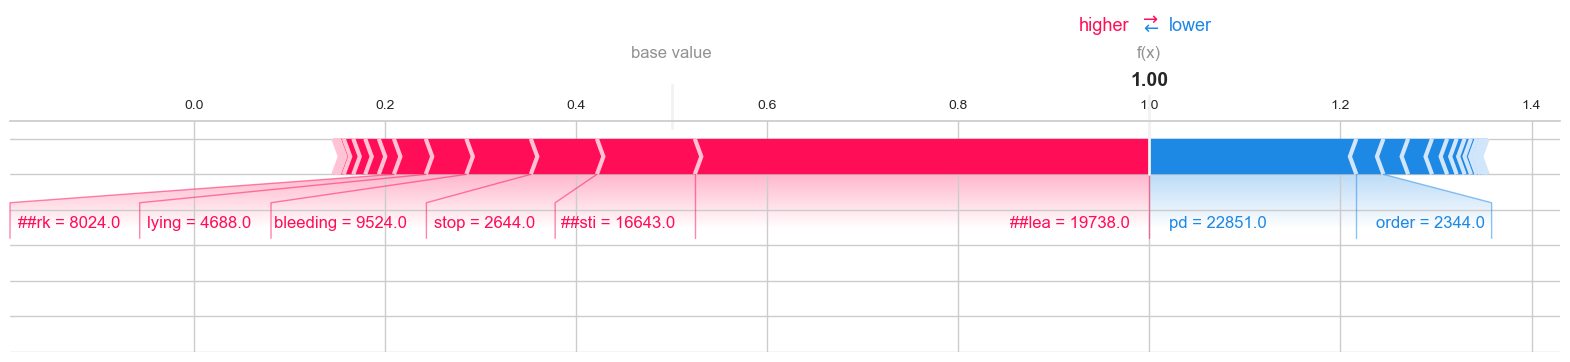

Sentence: force usa home gym exercises fitness equipment 690 ##00 ash ##more tc ##om ##4 ##l ##wn ##j ##z ##t ; Prediction: [1] ; True value: b'not_relevant'


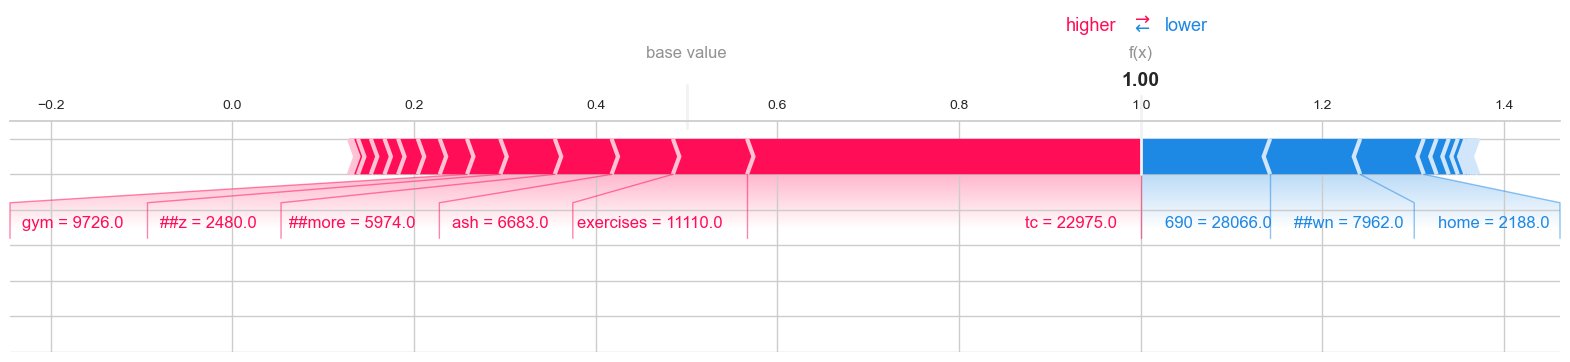

Sentence: interested diamonds ; Prediction: [0] ; True value: b'not_relevant'


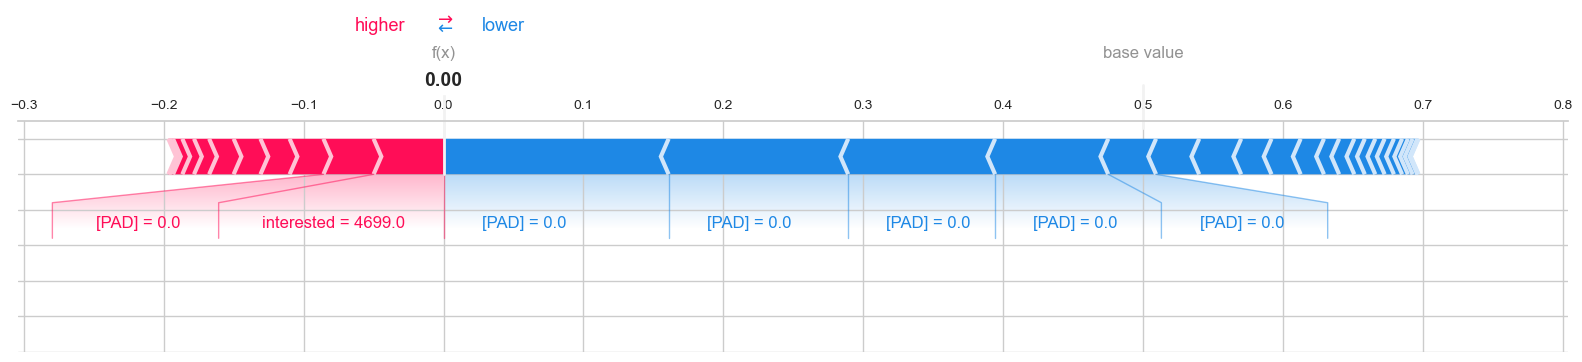

Sentence: news ja ##zee ##ra english jan 28 2013 06 ##55 flood worse ##ns eastern australia h ##t tc ##ou ##pu ##f ##ja ##q ##y tc ##oum ##zh ##od ##j ##0 ; Prediction: [1] ; True value: b'relevant'


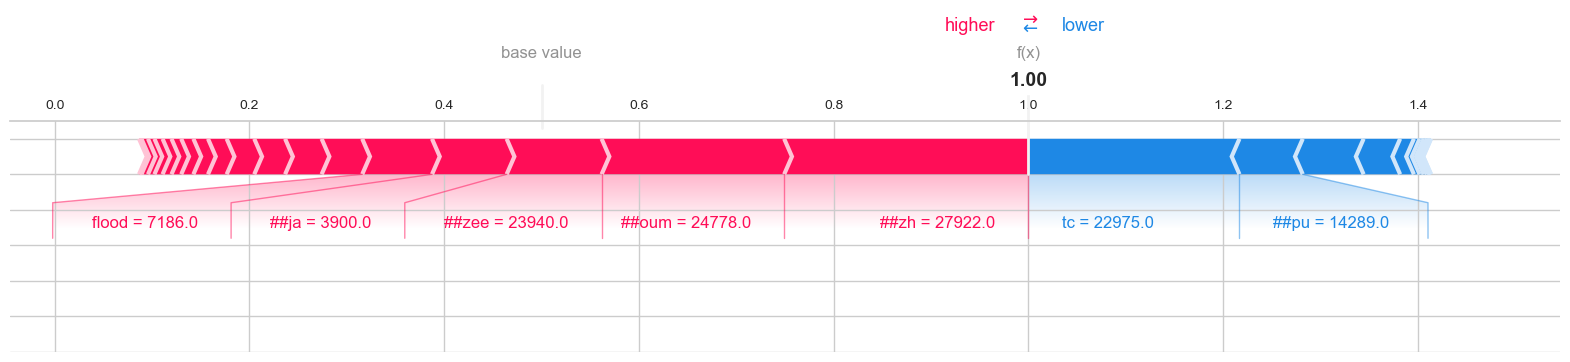

Sentence: big lad pump lead gear ja ##bber ; Prediction: [1] ; True value: b'not_relevant'


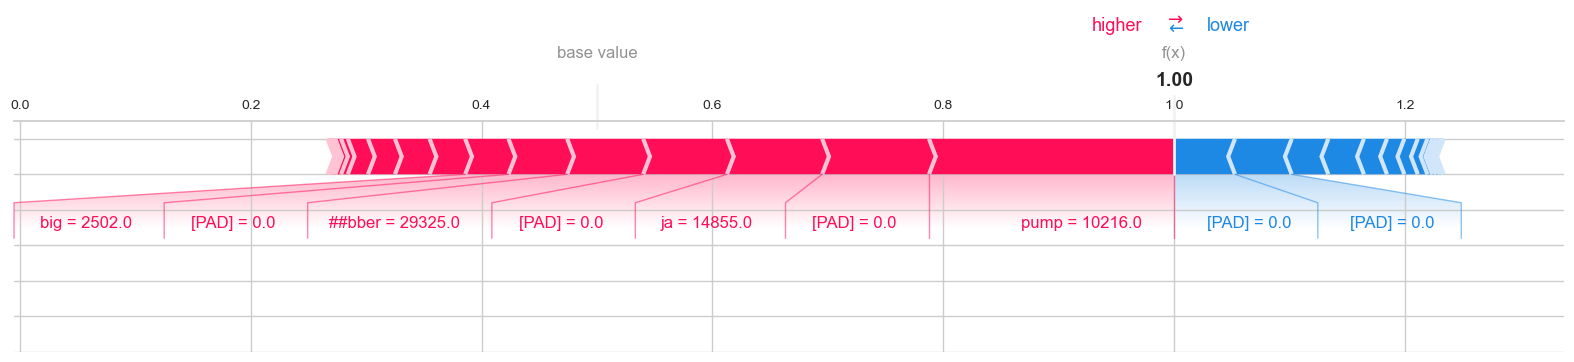

In [26]:
for i in range(len(X_test_padded)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(X_test_padded[i])).replace(" [PAD]", "") ,"; Prediction:", clf2.predict([X_test_padded[i]]), "; True value:", y_test[i])
  shap.plots.force(permutation_values.base_values[i], permutation_values.values[i], permutation_values.data[i], feature_names=tokenizer.convert_ids_to_tokens(permutation_values.data[i]), matplotlib=True)

In [27]:
permutation_explainer = None
permutation_values = None

In [28]:
import numpy as np
import torch
from nltk.tokenize import TweetTokenizer
import logging

logging.basicConfig(format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S")
logging.getLogger().setLevel(logging.INFO)


class SHAPexplainer:
    def __init__(self, model, tokenizer, words_dict, words_dict_reverse):
        self.model = model
        self.tokenizer = tokenizer
        self.device = "cpu"
        self.tweet_tokenizer = TweetTokenizer()
        self.words_dict = words_dict
        self.words_dict_reverse = words_dict_reverse

    def predict(self, indexed_words):
        # self.model.to(self.device)

        sentences = [
            [self.words_dict[xx] if xx != 0 else "" for xx in x] for x in indexed_words
        ]
        indexed_tokens, _, _ = self.tknz_to_idx(sentences)

        # ref = self.tweet_tokenizer.tokenize(data[0])
        # data_temp = [ref]
        # for x in data[1:]:
        #     ref_temp = ref.copy()
        #     new = ["" for _ in range(len(ref))]
        #     x = self.tweet_tokenizer.tokenize(x)
        #     for w in x:
        #         id = ref_temp.index(w)
        #         new[id] = w
        #         ref_temp[id] = ""
        #     data_temp.append(new)
        #
        # data_temp = [["[PAD]" if xx == "" else xx for xx in x] for x in data_temp]
        # data_temp = [" ".join(x) for x in data_temp]
        #
        # tokenized_nopad = [self.tokenizer.tokenize(text) for text in data_temp]
        # MAX_SEQ_LEN = max(len(x) for x in tokenized_nopad)
        # tokenized_text = [["[PAD]", ] * MAX_SEQ_LEN for _ in range(len(data))]
        # for i in range(len(data)):
        #     tokenized_text[i][0:len(tokenized_nopad[i])] = tokenized_nopad[i][0:MAX_SEQ_LEN]
        # indexed_tokens = [self.tokenizer.convert_tokens_to_ids(tt) for tt in tokenized_text]

        tokens_tensor = torch.tensor(indexed_tokens)
        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            # logits = outputs[0]
            predictions = np.array(outputs)
        final = [self.softmax(x) for x in predictions]
        return np.array(final)

    def softmax(self, it):
        exps = np.exp(np.array(it))
        return exps / np.sum(exps)

    def split_string(self, string):
        data_raw = self.tweet_tokenizer.tokenize(string)
        data_raw = [x for x in data_raw if x not in ".,:;'"]
        return data_raw

    def tknz_to_idx(self, train_data, MAX_SEQ_LEN=None):
        tokenized_nopad = [
            self.tokenizer.tokenize(" ".join(text)) for text in train_data
        ]
        if not MAX_SEQ_LEN:
            MAX_SEQ_LEN = min(max(len(x) for x in train_data), 512)
        tokenized_text = [
            [
                "[PAD]",
            ]
            * MAX_SEQ_LEN
            for _ in range(len(tokenized_nopad))
        ]
        for i in range(len(tokenized_nopad)):
            tokenized_text[i][0 : len(tokenized_nopad[i])] = tokenized_nopad[i][
                0:MAX_SEQ_LEN
            ]
        indexed_tokens = np.array(
            [
                np.array(self.tokenizer.convert_tokens_to_ids(tt))
                for tt in tokenized_text
            ]
        )
        return indexed_tokens, tokenized_text, MAX_SEQ_LEN

    def dt_to_idx(self, data, max_seq_len=None):
        idx_dt = [[self.words_dict_reverse[xx] for xx in x] for x in data]
        if not max_seq_len:
            max_seq_len = min(max(len(x) for x in idx_dt), 512)
        for i, x in enumerate(idx_dt):
            if len(x) < max_seq_len:
                idx_dt[i] = x + [0] * (max_seq_len - len(x))
        return np.array(idx_dt), max_seq_len


In [29]:
bag_of_words = []

for s in X_test_padded:
  for w in s:
    bag_of_words.append(w)

bag_of_words = np.unique(np.array(bag_of_words))

In [52]:
def predict_model(text_ids):
  bert_output = model(torch.from_numpy(np.array(text_ids)))
  sequence_output = bert_output[0].detach().numpy()
  print(clf.predict(sequence_output.reshape(text_ids.shape[0], 64*768)))
  return clf.predict(sequence_output.reshape(text_ids.shape[0], 64*768))

In [53]:
words_dict = {0:None}
words_dict_reverse = {None:0}

for w in bag_of_words:
    token = tokenizer.convert_ids_to_tokens([w])[0]
    words_dict[w] = token
    words_dict_reverse[token] = w

predictor = SHAPexplainer(predict_model, tokenizer, words_dict, words_dict_reverse)

In [54]:
test_text = []
for i in range(len(X_test_padded)):
  test_text.append(tokenizer.convert_ids_to_tokens(X_test_padded[i]))

In [55]:
idx_test_data, max_seq_len = predictor.dt_to_idx(test_text)
print(test_text[0])
print(idx_test_data)
print(max_seq_len)

['baby', '##y', '##y', 'game', 'co', '##s', 'n', '##xt', 'the', '##week', '##nd', '##ly', '##ric', '##s', 'bed', '##time', '##music', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[[ 3336  2100  2100 ...     0     0     0]
 [ 5322  1055  7186 ...     0     0     0]
 [23961  3233 18255 ...     0     0     0]
 ...
 [ 4699 11719     0 ...     0     0     0]
 [ 2739 14855 23940 ...     0     0     0]
 [ 2502 14804 10216 ...     0     0     0]]
64


In [56]:
explainer = shap.KernelExplainer(model=predictor.predict, data=idx_test_data[:20])

#texts_ = [predictor.split_string(x) for x in test_text]
idx_texts, _ = predictor.dt_to_idx(test_text, max_seq_len=max_seq_len)

[0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1]


In [2]:
to_use = idx_texts[:20]
shap_values = explainer.shap_values(X=to_use, nsamples=64, l1_reg="aic")

TypeError: explain_row() missing 5 required keyword-only arguments: 'max_evals', 'main_effects', 'error_bounds', 'outputs', and 'silent'

In [58]:
print(shap_values)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [59]:
len_ = len(test_text[0])
d = {i: sum(x > 0 for x in shap_values[i][0:len_]) for i in range(len(shap_values))}
m = max(d, key=d.get)
print(" ".join(test_text[-1:][0]))
shap.force_plot(explainer.expected_value, shap_values[m][0:len_], test_text[0])

big lad pump lead gear ja ##bber [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [1]:
import dill
filename = 'globalsave.pkl'
#dill.dump_session(filename)

# and to load the session again:
dill.load_session(filename)